# Análisis Predictivo de Series Temporales



## Redes Neuronales aplicadas a Series Temporales


## Objetivo

El objetivo de este cuaderno es introducir algunos ejemplos de ajuste de redes neuronales en el contexto de análsiis de series temporales. En particular:

 * Discutir cómo convertir el problema de ajuste de modelos a un problema de aprendizaje supervisado.
 
 * Analizar la relación entre RNN clásicas y los modelos lineales ya vistos.
 
 * Discutir algunos ejemplos más complejos de redes (CNN, RNN, LSTM).
 
 * Observar cómo se puede realizar la predicción.
 
 
Nos basaremos en la biblioteca `tensorflow`, por lo que es necesario una instalación de Python con tensorflow para que funcione. En particular usaremos la biblioteca `keras` para interactuar de manera sencilla con `tensorflow`

In [2]:
## Ejemplo: instalación de astsadata usando pip:
#!pip install astsadata

## Ajusto tamaño de figuras
import matplotlib.pyplot as plt
import astsadata as astsa
import numpy as np
import statsmodels.api as sm
import pandas as pd
import tensorflow as tf
import keras

plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

### Ejemplo

Trabajaremos en un principio con la serie de mortalidad que ya vimos:

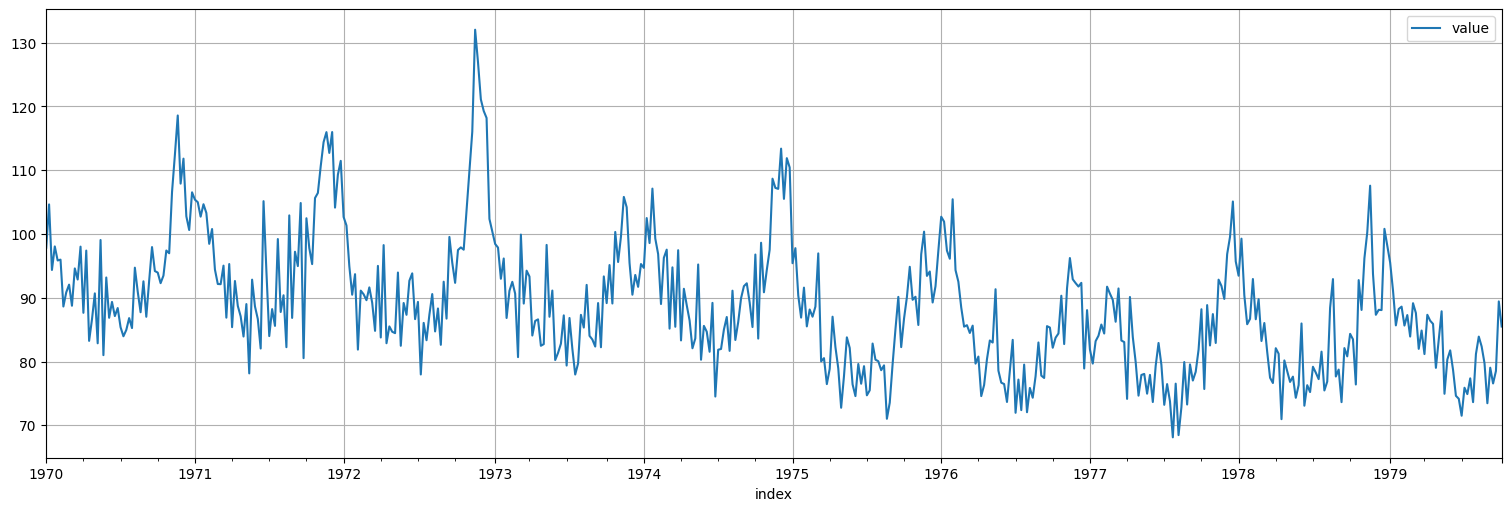

In [3]:
cmort = astsa.cmort
cmort.plot();

### Estacionarización

Como vimos antes, resulta útil llevar primero la serie a algo estacionario. En este caso, le quitamos la tendencia.

In [4]:
from statsmodels.formula.api import ols

time = pd.Series([idx.ordinal for idx in cmort.index], index=cmort.index, name="Semana")
data = pd.concat([cmort, time], axis=1).dropna()

fit = ols(formula="cmort~time", data=data).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  cmort   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     135.0
Date:                Tue, 11 Jun 2024   Prob (F-statistic):           8.03e-28
Time:                        16:09:58   Log-Likelihood:                -1829.9
No. Observations:                 508   AIC:                             3664.
Df Residuals:                     506   BIC:                             3672.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     96.6510      0.790    122.335      0.000      95.099      98.203
time          -0.0312      0.003    -11.618      0.000      -0.036      -0.026
==============================================================================
Omnibus:                       67.579   Durbin-Watson:                   0.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.699
Skew:                           0.906   Prob(JB):                     6.09e-22
Kurtosis:                       4.156   Cond. No.                         590.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

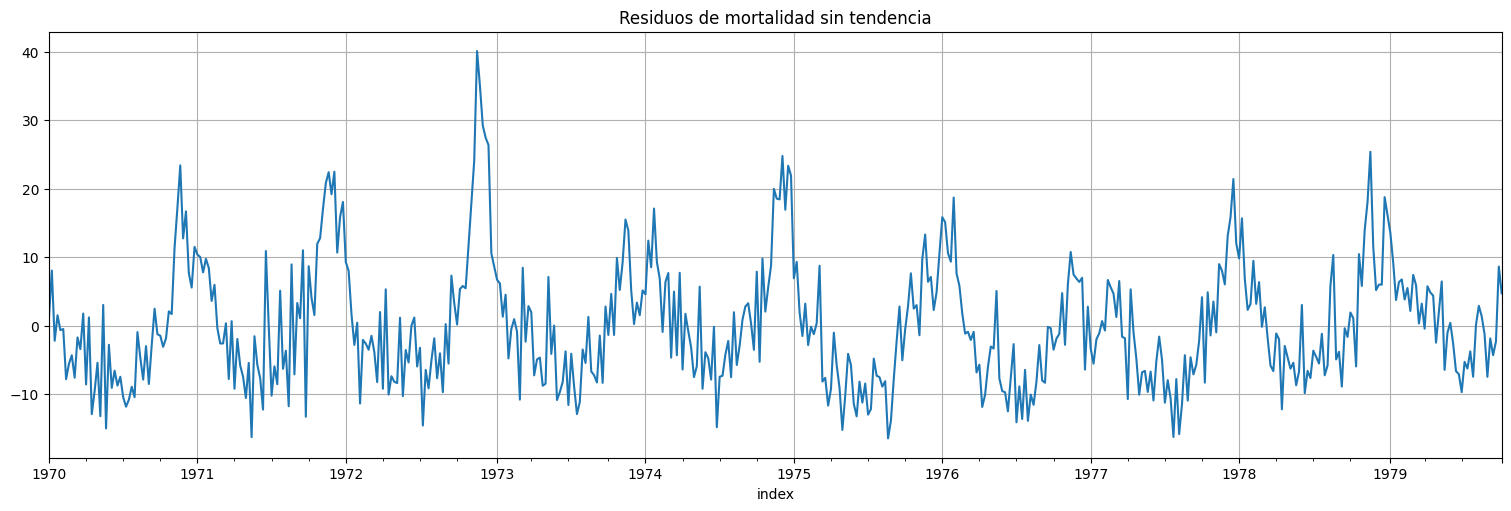

In [5]:
x=fit.resid
x.plot()
plt.title("Residuos de mortalidad sin tendencia");

## Aprendizaje en series temporales

Las redes neuronales sirven para realizar aprendizaje *supervisado*, esto es, a partir de ejemplos, encontrar los coeficientes de la red que minimizan una función de *loss* o pérdida. En este caso:

* Los ejemplos son "ventanas" de valores en el tiempo de la serie, y uno o más features que nos interese incorporar:

     * Por ejemplo, el valor de la semana del año en este caso importa debido a la variación anual.
     * Pueden ser también diferentes "features" como la temperatura y partículas que ya vimos.
     
* El valor a predecir es por ejemplo, el siguiente valor de la serie, o una ventana hacia adelante.

* En base a esto, se arma una arquitectura de red y se entrena usando backpropagation.

### Diagrama

Para el caso por ejemplo de tomar 6 lags:

![split window](../images/split_window.png)

### Preprocesamiento

En este caso, haremos varios modelos. El primero simplemente usa como feature la propia serie, usando una cantidad `window` de lags hacia atrás. Separamos ademas una parte para testear predicciones.

Ahora debemos rearmar los datos para el formato `tensorflow`:

 * Cada feature es un vector conteniendo una ventana de `window` datos de la serie.
 * Cada valor observado es un vector (en este caso escalar) con los datos a predecir `pred`.

La función `keras.utils.timeseties_dataset_from_array()` nos permite hacer esto ordenado (aunque con algunos *pitfalls*):

In [241]:
window = 3 #lags a mirar

input_data = x.values[:-window]
targets = x.values[window:]

dataset = keras.utils.timeseries_dataset_from_array( input_data, targets, 
                                                     sequence_length=window,
                                                     batch_size=16)

train, test = keras.utils.split_dataset(dataset,0.8)

2024-06-11 18:50:07.958549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [242]:
train.as_numpy_iterator().next()

(array([[  1.23010434,   8.05125614,  -2.19759207],
        [  8.05125614,  -2.19759207,   1.52355972],
        [ -2.19759207,   1.52355972,  -0.64528849],
        [  1.52355972,  -0.64528849,  -0.4841367 ],
        [ -0.64528849,  -0.4841367 ,  -7.8029849 ],
        [ -0.4841367 ,  -7.8029849 ,  -5.55183311],
        [ -7.8029849 ,  -5.55183311,  -4.31068132],
        [ -5.55183311,  -4.31068132,  -7.58952953],
        [ -4.31068132,  -7.58952953,  -1.70837773],
        [ -7.58952953,  -1.70837773,  -3.41722594],
        [ -1.70837773,  -3.41722594,   1.77392585],
        [ -3.41722594,   1.77392585,  -8.57492236],
        [  1.77392585,  -8.57492236,   1.21622943],
        [ -8.57492236,   1.21622943, -12.91261877],
        [  1.21622943, -12.91261877,  -9.52146698],
        [-12.91261877,  -9.52146698,  -5.40031519]]),
 array([  1.52355972,  -0.64528849,  -0.4841367 ,  -7.8029849 ,
         -5.55183311,  -4.31068132,  -7.58952953,  -1.70837773,
         -3.41722594,   1.77392585,  -

## Modelo 1: una única neurona densa.

Esto, sin agregar no linealidades, debería coincidir con el modelo autorregresivo que ya vimos.

In [243]:
model = keras.Sequential([
    keras.Input(shape=(window,)),
    keras.layers.Dense(units=1)
])

model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_37 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4 (16.00 B)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 0 (0.00 B)

In [244]:
model.compile(loss="mse",
              optimizer = "adam",
              metrics = ["mse"])

In [245]:
history = model.fit(
    train,
    epochs=300, 
    verbose=False,
    validation_data=test
)

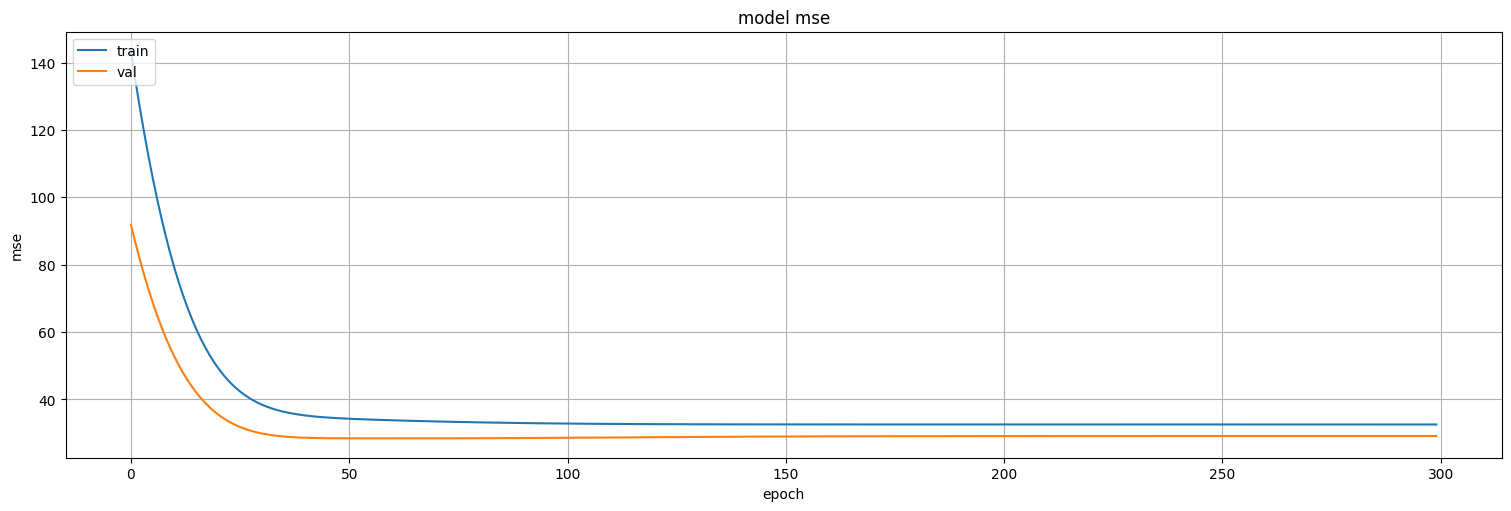

In [246]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [247]:
model.get_weights()

[array([[0.01882242],
        [0.45390654],
        [0.36636686]], dtype=float32),
 array([-0.10694283], dtype=float32)]

In [248]:
pred = model.predict(dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


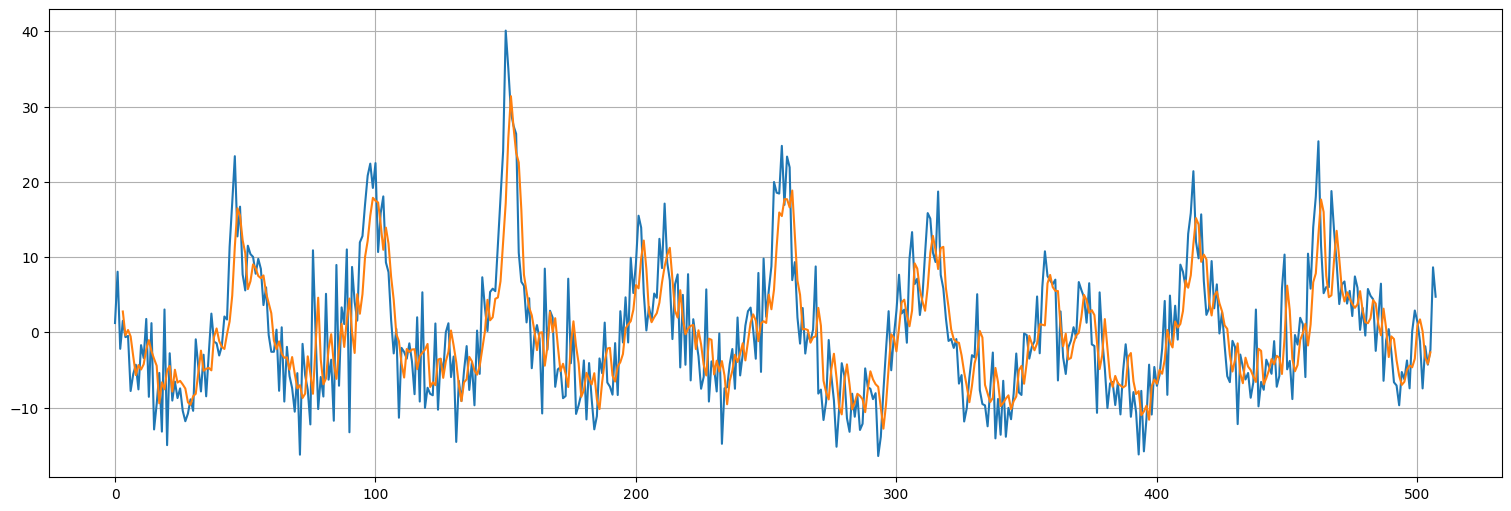

In [249]:
plt.plot(x.values)
plt.plot(range(window,x.size-window+1),pred);

In [265]:
from statsmodels.tsa.api import ARIMA

x_train=x.iloc[:406]
arima = ARIMA(x_train,order=(window,0,0), trend='n').fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  406
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -1283.357
Date:                Tue, 11 Jun 2024   AIC                           2574.715
Time:                        18:52:49   BIC                           2590.740
Sample:                    01-04-1970   HQIC                          2581.057
                         - 10-16-1977                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3795      0.044      8.552      0.000       0.293       0.466
ar.L2          0.4592      0.050      9.118      0.000       0.361       0.558
ar.L3          0.0042      0.052      0.082      0.935      -0.097       0.105
sigma2        32.4984      2.097     15.501      0.000      28.389      36.608
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.95
Prob(Q):                              0.98   Prob(JB):                         0.01
Heteroskedasticity (H):               0.73   Skew:                             0.30
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [266]:
arima.mse

32.52776067644698

In [268]:
model.evaluate(train)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 33.2679 - mse: 33.2679


[32.54790496826172, 32.54790496826172]

## Modelo 2: múltiples capas densas

Agreguemos algunas capas para darle no linealidad al modelo. Usamos como función de activación `relu`, es decir $a(x)=\max\{x,0\}$.

In [269]:
model2 = keras.Sequential([
    keras.Input(shape=(window,)),
    keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

model2.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

In [270]:
model2.compile(loss="mse",
              optimizer = "adam",
              metrics = ["mse"])

In [271]:
history = model2.fit(
    train,
    epochs=200, 
    verbose=False,
    validation_data=test
)

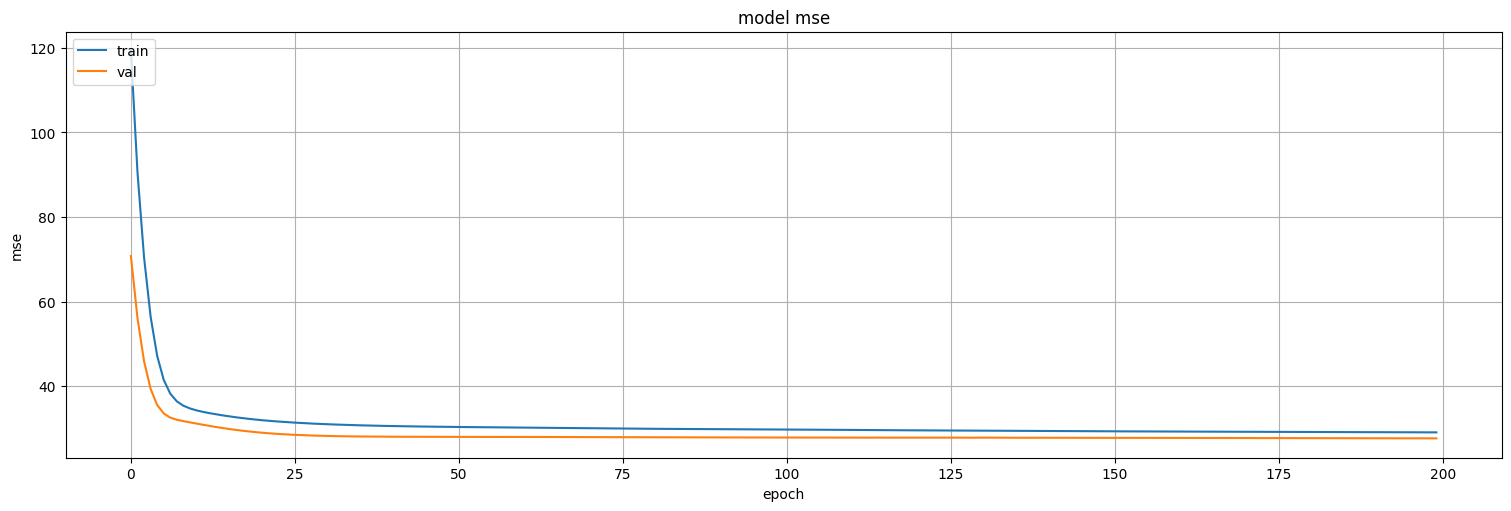

In [272]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [273]:
model.evaluate(test)
model2.evaluate(test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 30.3379 - mse: 30.3379
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 28.2520 - mse: 28.2520


[27.70163345336914, 27.70163345336914]

In [274]:
pred = model2.predict(dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


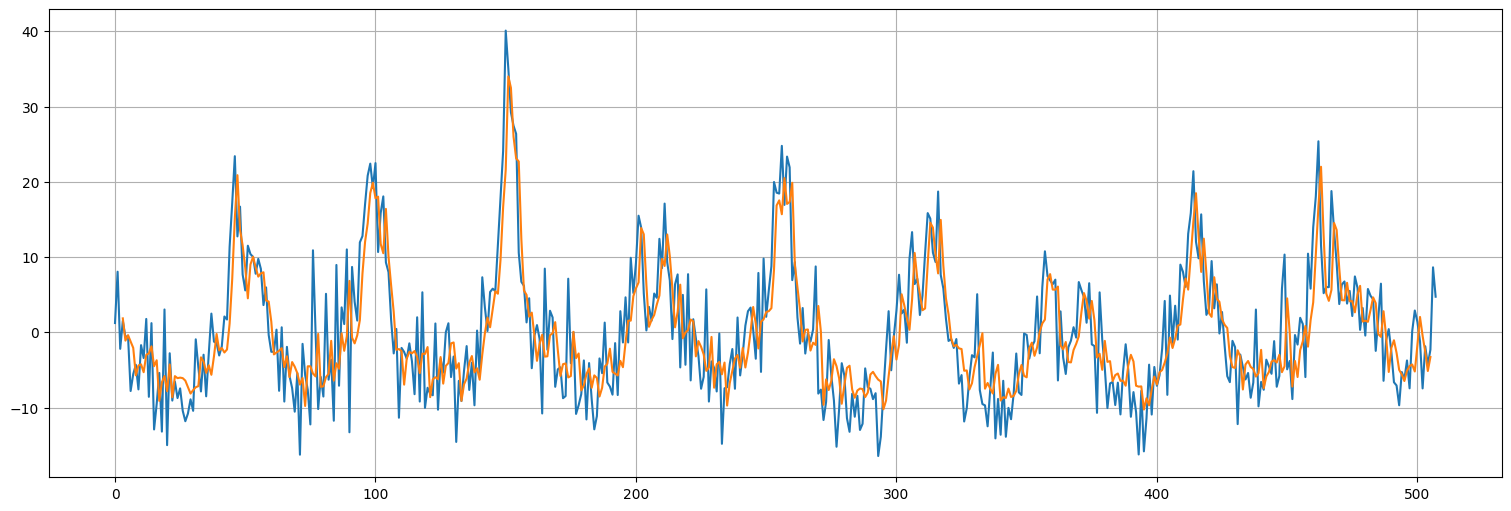

In [275]:
plt.plot(x.values)
plt.plot(range(window,x.size-window+1),pred);

## Modelo 3: agregando características

Agreguemos ahora al conjunto de entrenamiento algunas funciones del tiempo. Por ejemplo, la semana del año:

### Preprocesamiento

In [418]:
window = 3 #lags a mirar

n = x.size-window
week = [x.index[i].weekofyear for i in range(0,n)]
#cost = np.cos(2*np.pi*freq*t)
#sint = np.sin(2*np.pi*freq*t)

features = 2
input_data = np.stack([x.values[:-window],week], axis=1)

targets = x.values[window:]

dataset = keras.utils.timeseries_dataset_from_array(input_data, targets, sequence_length=window, batch_size=1)

train, test = keras.utils.split_dataset(dataset,0.8)

2024-06-11 23:46:19.564004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Ajuste

In [419]:
model3 = keras.Sequential([
    keras.Input(shape=(window,features)),
    keras.layers.Reshape((1,window*features)),
    tf.keras.layers.Dense(units=1)
])

model3.summary()

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_27 (Reshape)            │ (None, 1, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1, 1)           │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

In [420]:
model3.compile(loss="mse",
              optimizer = "adam",
              metrics = ["mse"])

In [421]:
history = model3.fit(
    train,
    epochs=200,
    verbose=False,
    validation_data=test
)

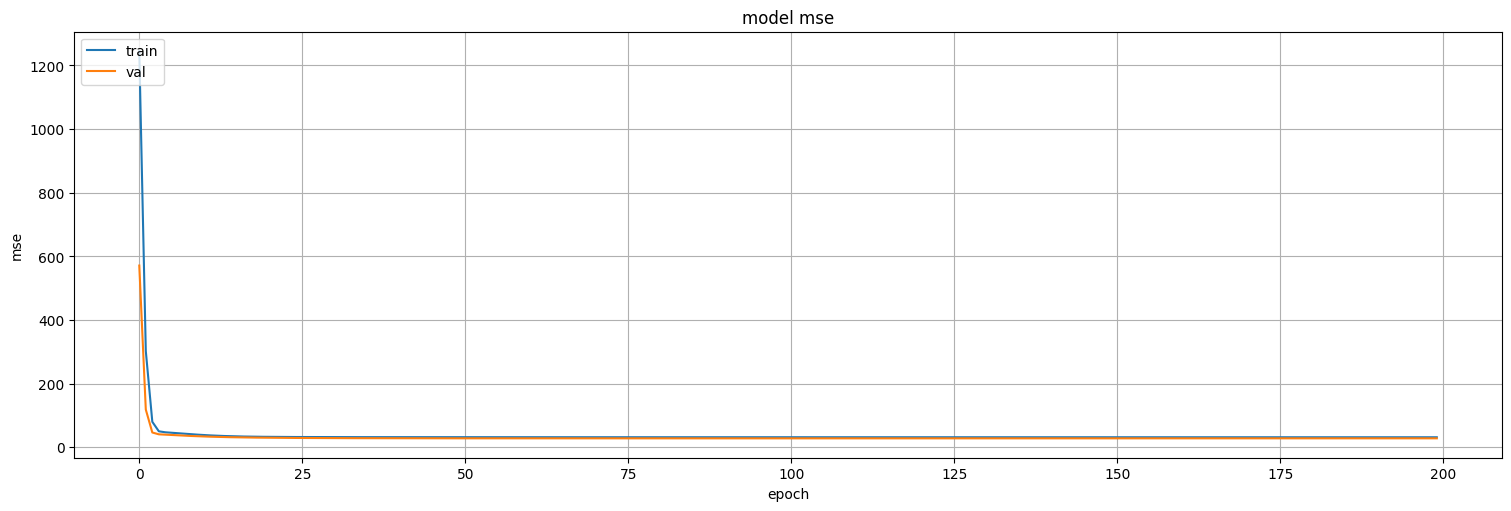

In [422]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [423]:
model3.evaluate(test)

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 27.8444 - mse: 27.8444


[28.138547897338867, 28.138547897338867]

In [424]:
pred = model3.predict(dataset)
pred = np.reshape(pred,(len(x)-2*window+1,1))

503/503 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


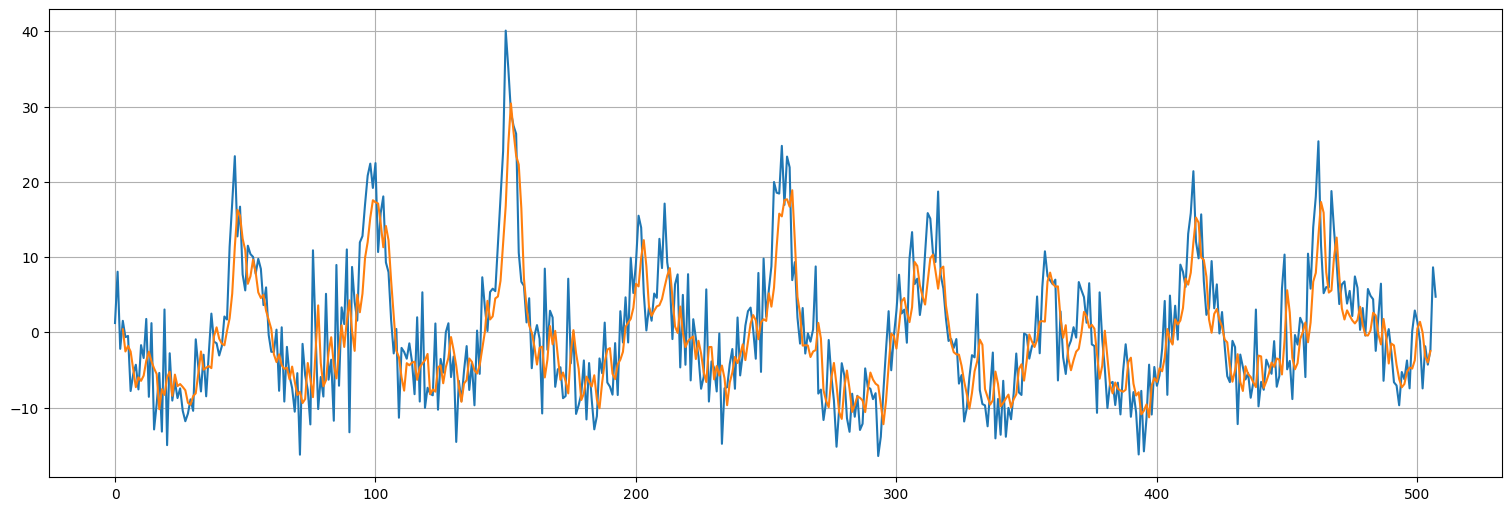

In [425]:
plt.plot(x.values)
plt.plot(range(window,len(x)-window+1),pred);

## Modelo 4: características y capas

Agreguemos un par de capas densas intermedias

In [440]:
model4 = keras.Sequential([
    keras.Input(shape=(window,features)),
    keras.layers.Reshape((1,window*features)),
    keras.layers.Dense(units=16,activation="relu"),
    keras.layers.Dense(units=8,activation="relu"),
    tf.keras.layers.Dense(units=1)
])

model4.summary()

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_30 (Reshape)            │ (None, 1, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1, 16)          │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1, 8)           │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1, 1)           │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257 (1.00 KB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

In [441]:
model4.compile(loss="mse",
              optimizer = "adam",
              metrics = ["mse"])

In [442]:
history = model4.fit(
    train,
    epochs=200,
    verbose=False,
    validation_data=test
)

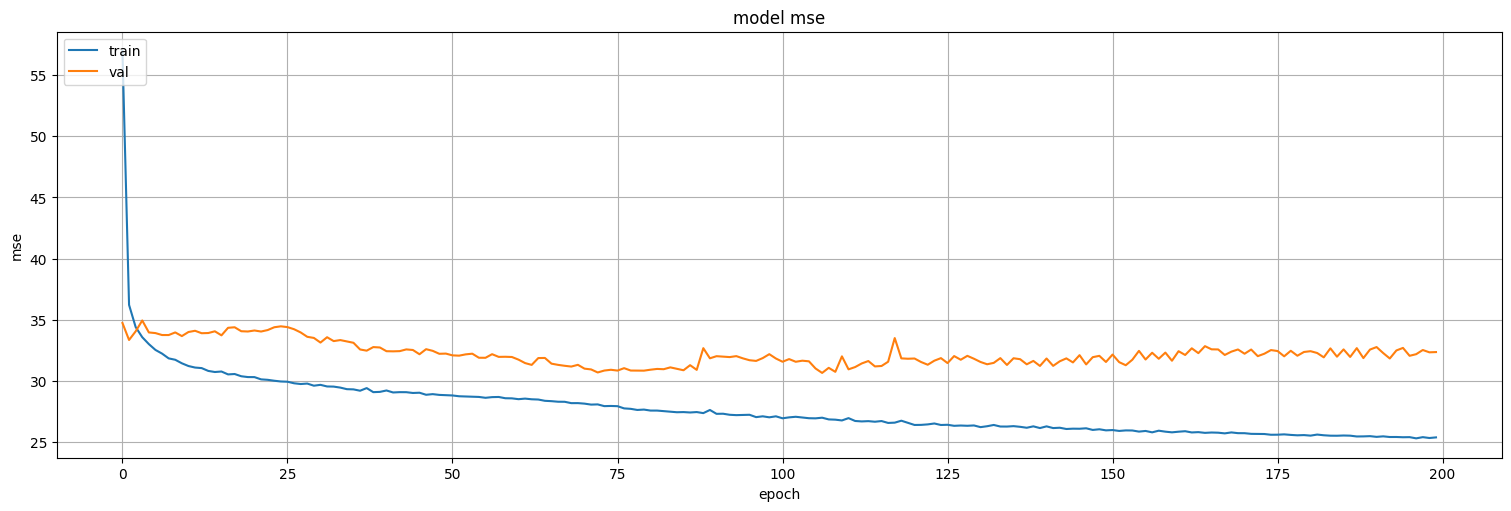

In [443]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [444]:
model4.evaluate(test)

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 33.1670 - mse: 33.1670


[32.346187591552734, 32.346187591552734]

In [445]:
pred = model4.predict(dataset)
pred = np.reshape(pred,(len(x)-2*window+1,1))

503/503 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


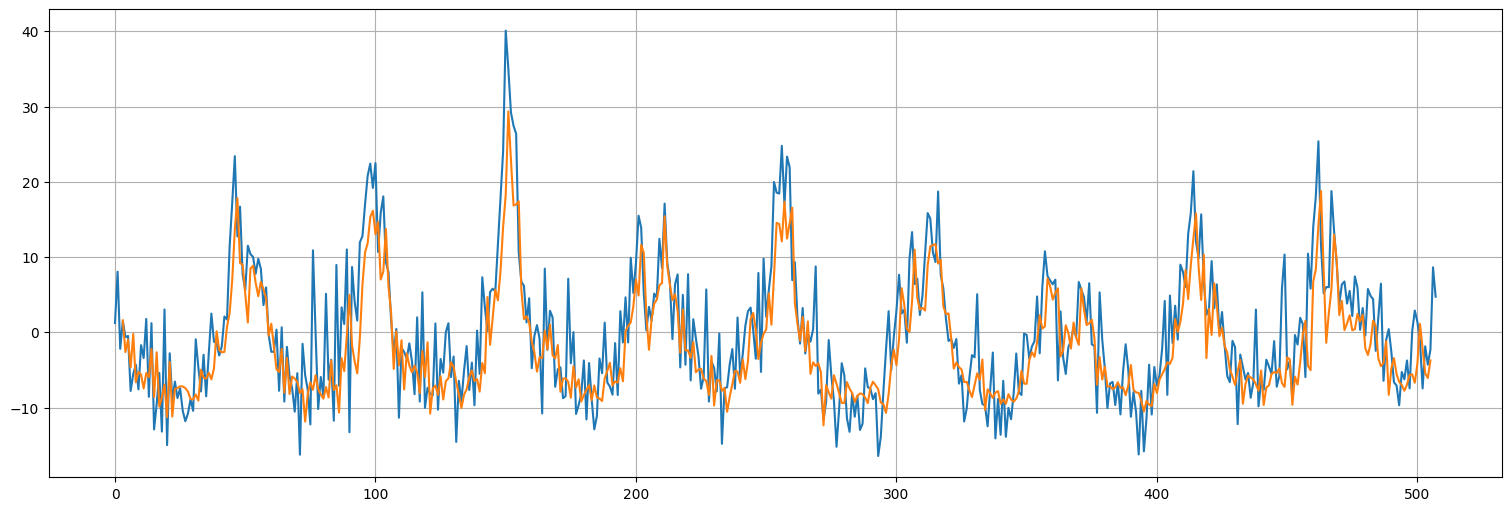

In [446]:
plt.plot(x.values)
plt.plot(range(window,len(x)-window+1),pred);

## Modelo 5: Convolutional Neural Network

La idea de la capa convolucional o CNN es similar a la de los procesos autorregresivos y a lo que veníamos haciendo antes, solo que simplifica un poco la escritura del modelo. El de abajo es esencialmente el mismo modelo 4 pero usando CNNs.

![CNN](../images/cnn.png)

In [451]:
model5 = keras.Sequential([
    keras.Input(shape=(window,features)),
    #keras.layers.Reshape((1,window*features)),
    keras.layers.Conv1D(filters=16, kernel_size=window, activation="relu"),
    keras.layers.Dense(units=8,activation="relu"),
    tf.keras.layers.Dense(units=1)
])

model5.summary()

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 1, 16)          │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1, 8)           │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1, 1)           │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257 (1.00 KB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

In [452]:
model5.compile(loss="mse",
              optimizer = "adam",
              metrics = ["mse"])

In [453]:
history = model5.fit(
    train,
    epochs=200,
    verbose=False,
    validation_data=test
)

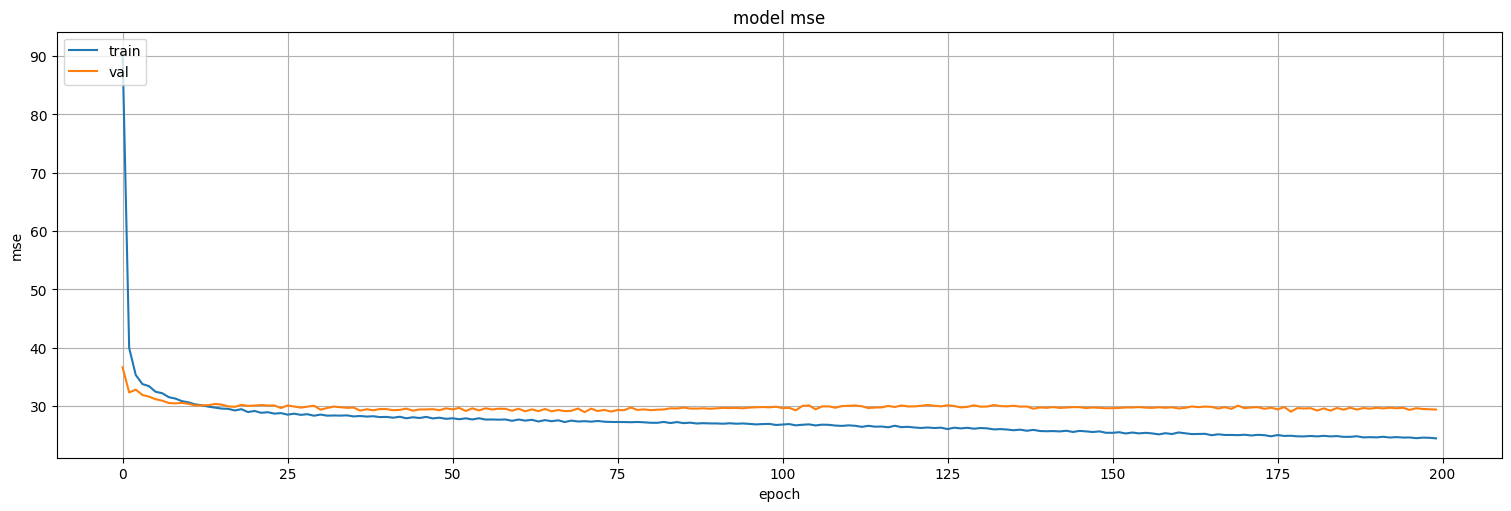

In [454]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [455]:
model5.evaluate(test)

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 28.4675 - mse: 28.4675


[29.436254501342773, 29.436254501342773]

In [456]:
pred = model5.predict(dataset)
pred = np.reshape(pred,(len(x)-2*window+1,1))

503/503 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step


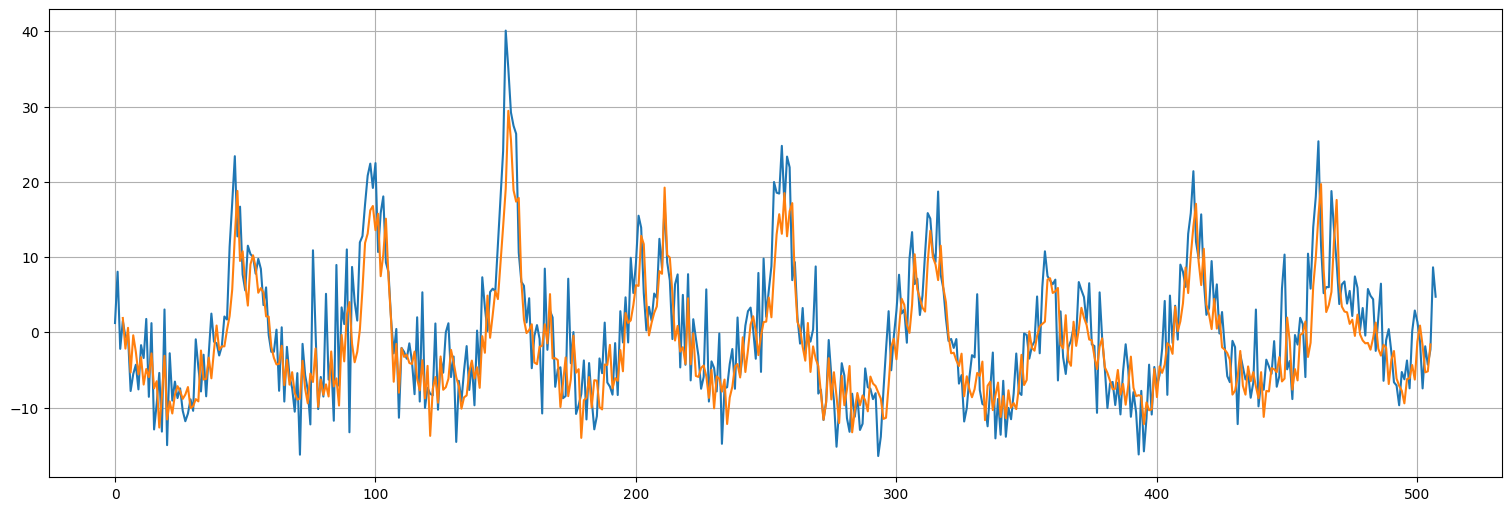

In [457]:
plt.plot(x.values)
plt.plot(range(window,len(x)-window+1),pred);

In [458]:
# initialize our model
model5 <- keras_model_sequential()

model5 %>%
    layer_conv_1d(input_shape = dim(X_train)[2:3], filters = 32, kernel_size=window, activation="relu") %>%
    layer_dense(units = 16, activation="relu") %>%
    layer_dense(units = 1)

SyntaxError: invalid syntax (2422585347.py, line 4)

In [41]:
summary(model5)

Model: "sequential_4"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv1d (Conv1D)                    (None, 1, 32)                   320         
 dense_8 (Dense)                    (None, 1, 16)                   528         
 dense_7 (Dense)                    (None, 1, 1)                    17          
Total params: 865
Trainable params: 865
Non-trainable params: 0
________________________________________________________________________________


In [42]:
model5 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [43]:
trained_model5 <- model5 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


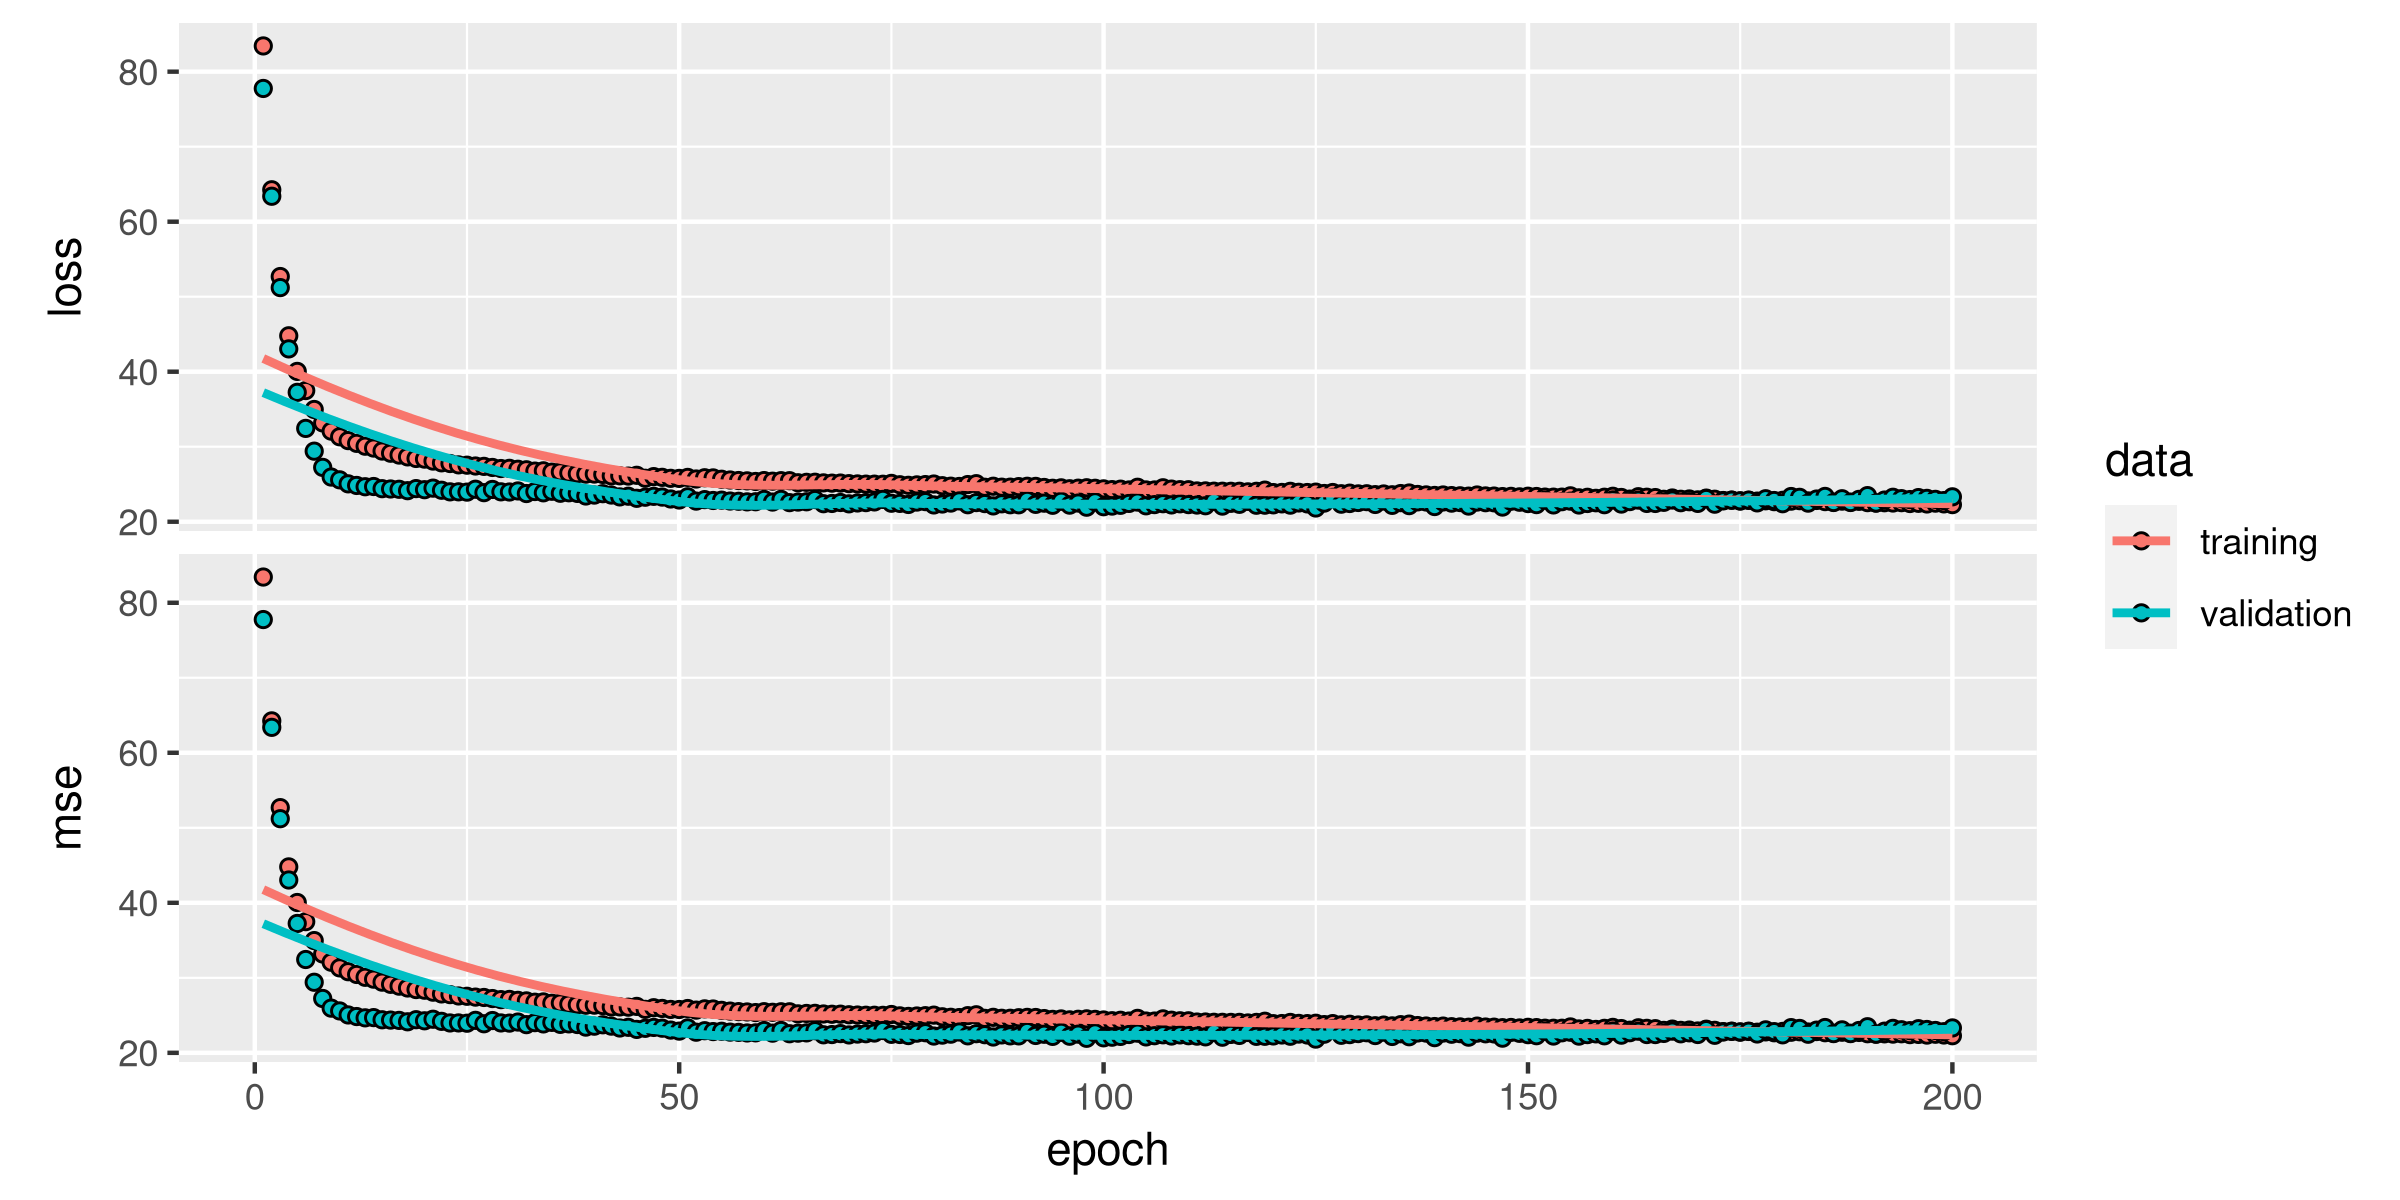

In [44]:
plot(trained_model5)

In [45]:
evaluate(model5, X_train, y_train)

loss      mse 
22.28619 22.28619

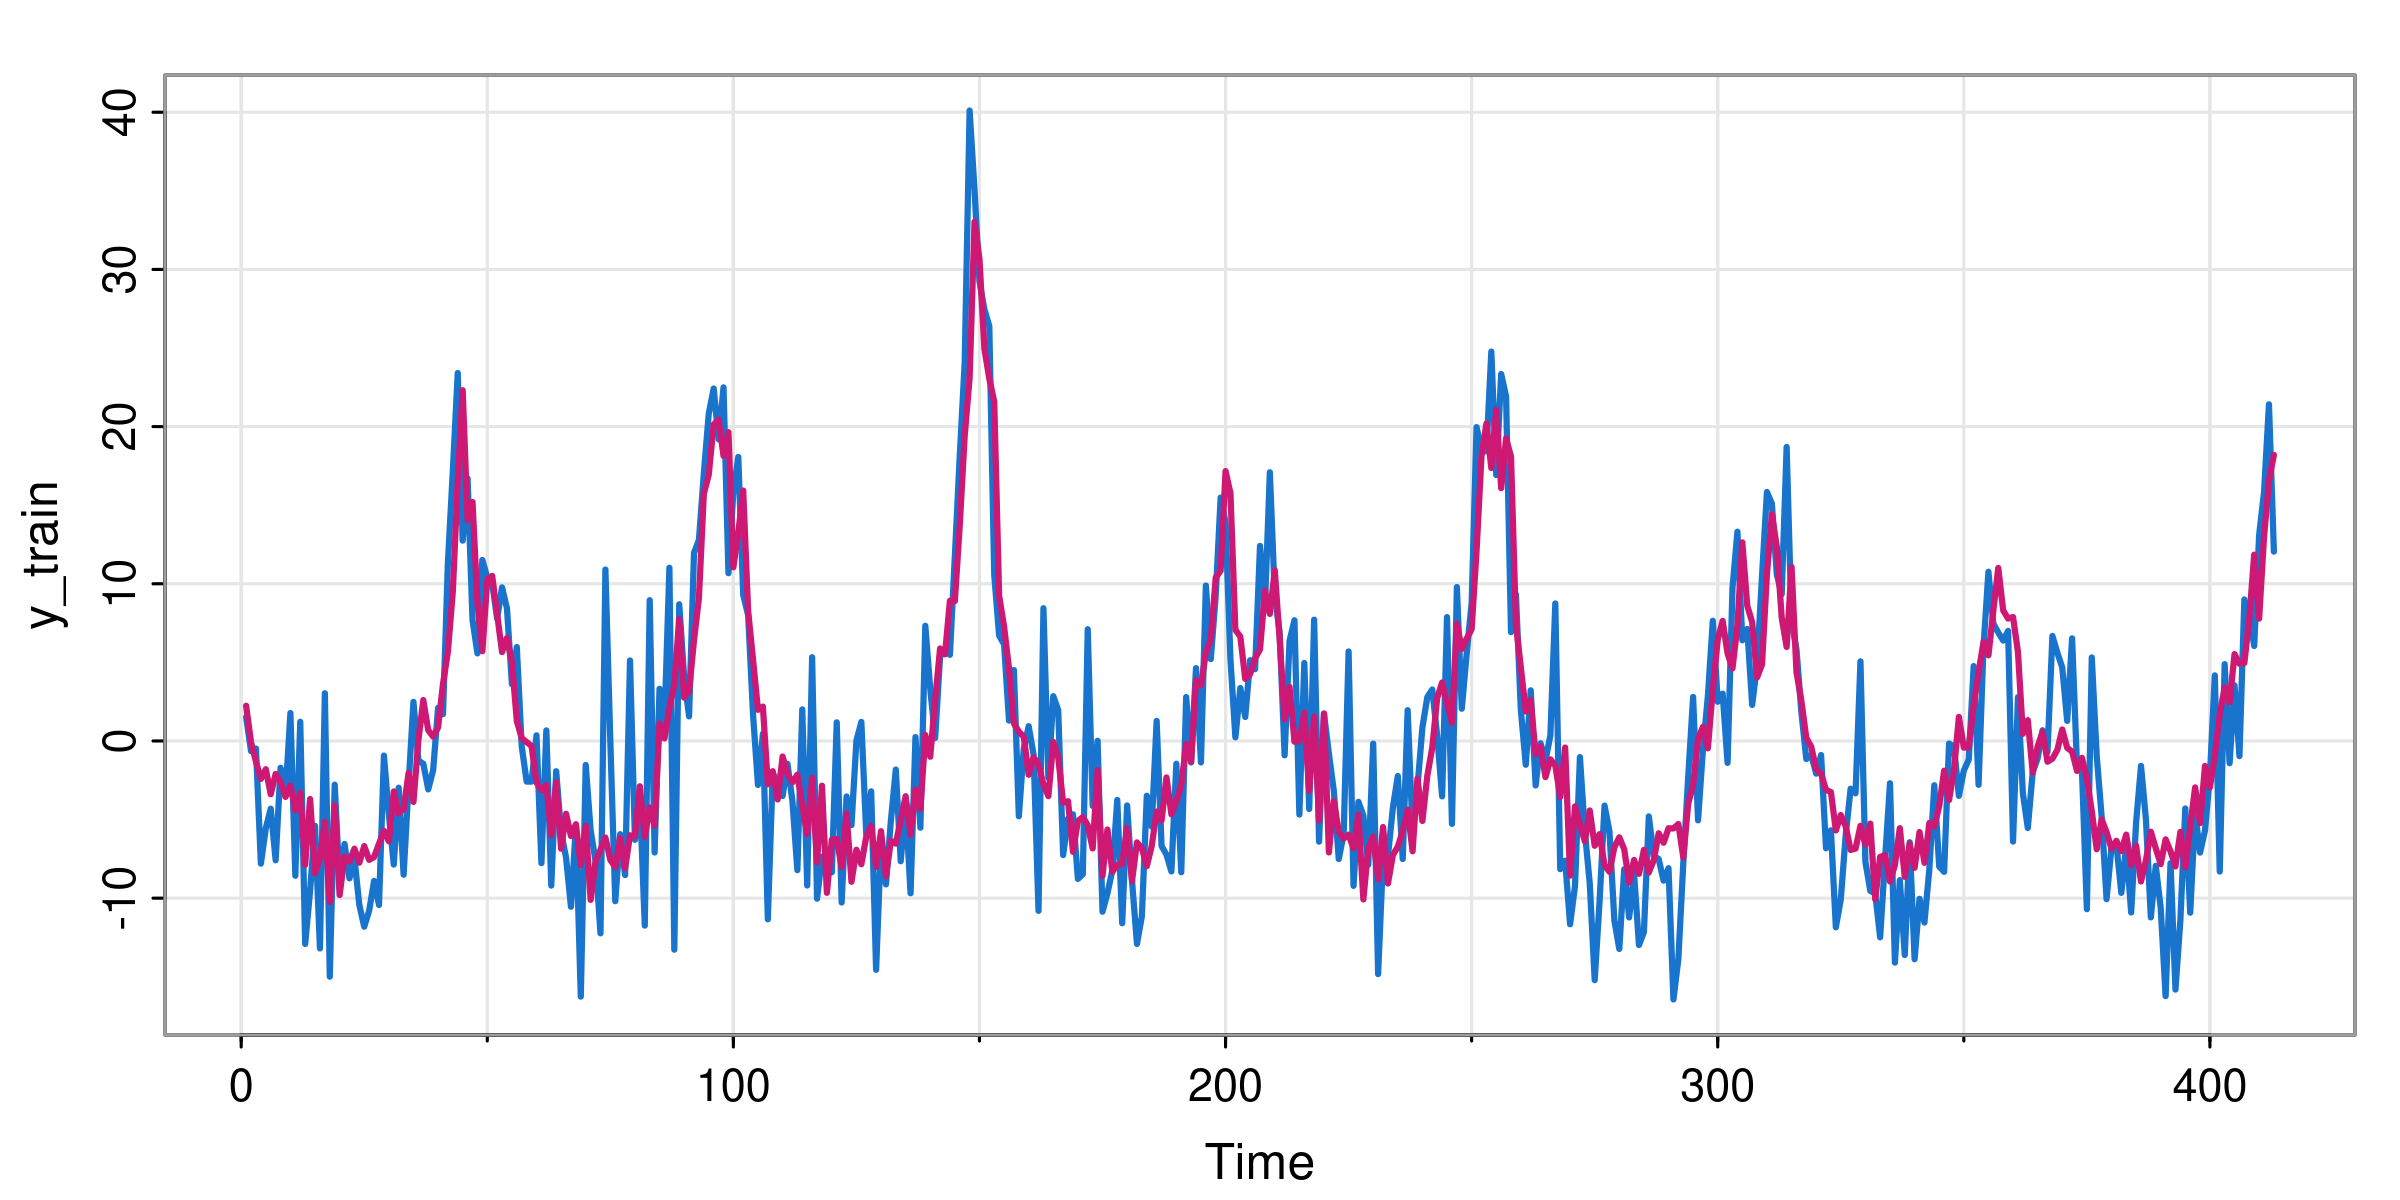

In [46]:
y5 = predict(model5,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y5, col=6, lwd=2)

## Recurrent Neural Networks

Estas redes permiten "guardar estado" y en algún sentido son la generalización no lineal del Dynamic Linear model que ya vimos. Permiten en algún sentido agregar memoria.

El proceso en una capa RNN es:

![RNN](../images/rnn.png)

## Modelo 6: Simple RNN

La red recurrente simple tiene "memoria corta" y presenta problemas de ajuste ("vanishing and exploding gradiemts") cuando uno hace el algoritmo de Backpropagation adaptado a las mismas.

In [47]:
# initialize our model
model6 <- keras_model_sequential()

model6 %>%
    layer_simple_rnn(input_shape = dim(X_train)[2:3], units = 8, activation="relu") %>%
    layer_dense(units = 1)

In [48]:
summary(model6)

Model: "sequential_5"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 simple_rnn (SimpleRNN)             (None, 8)                       96          
 dense_9 (Dense)                    (None, 1)                       9           
Total params: 105
Trainable params: 105
Non-trainable params: 0
________________________________________________________________________________


In [49]:
model6 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [50]:
trained_model6 <- model6 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


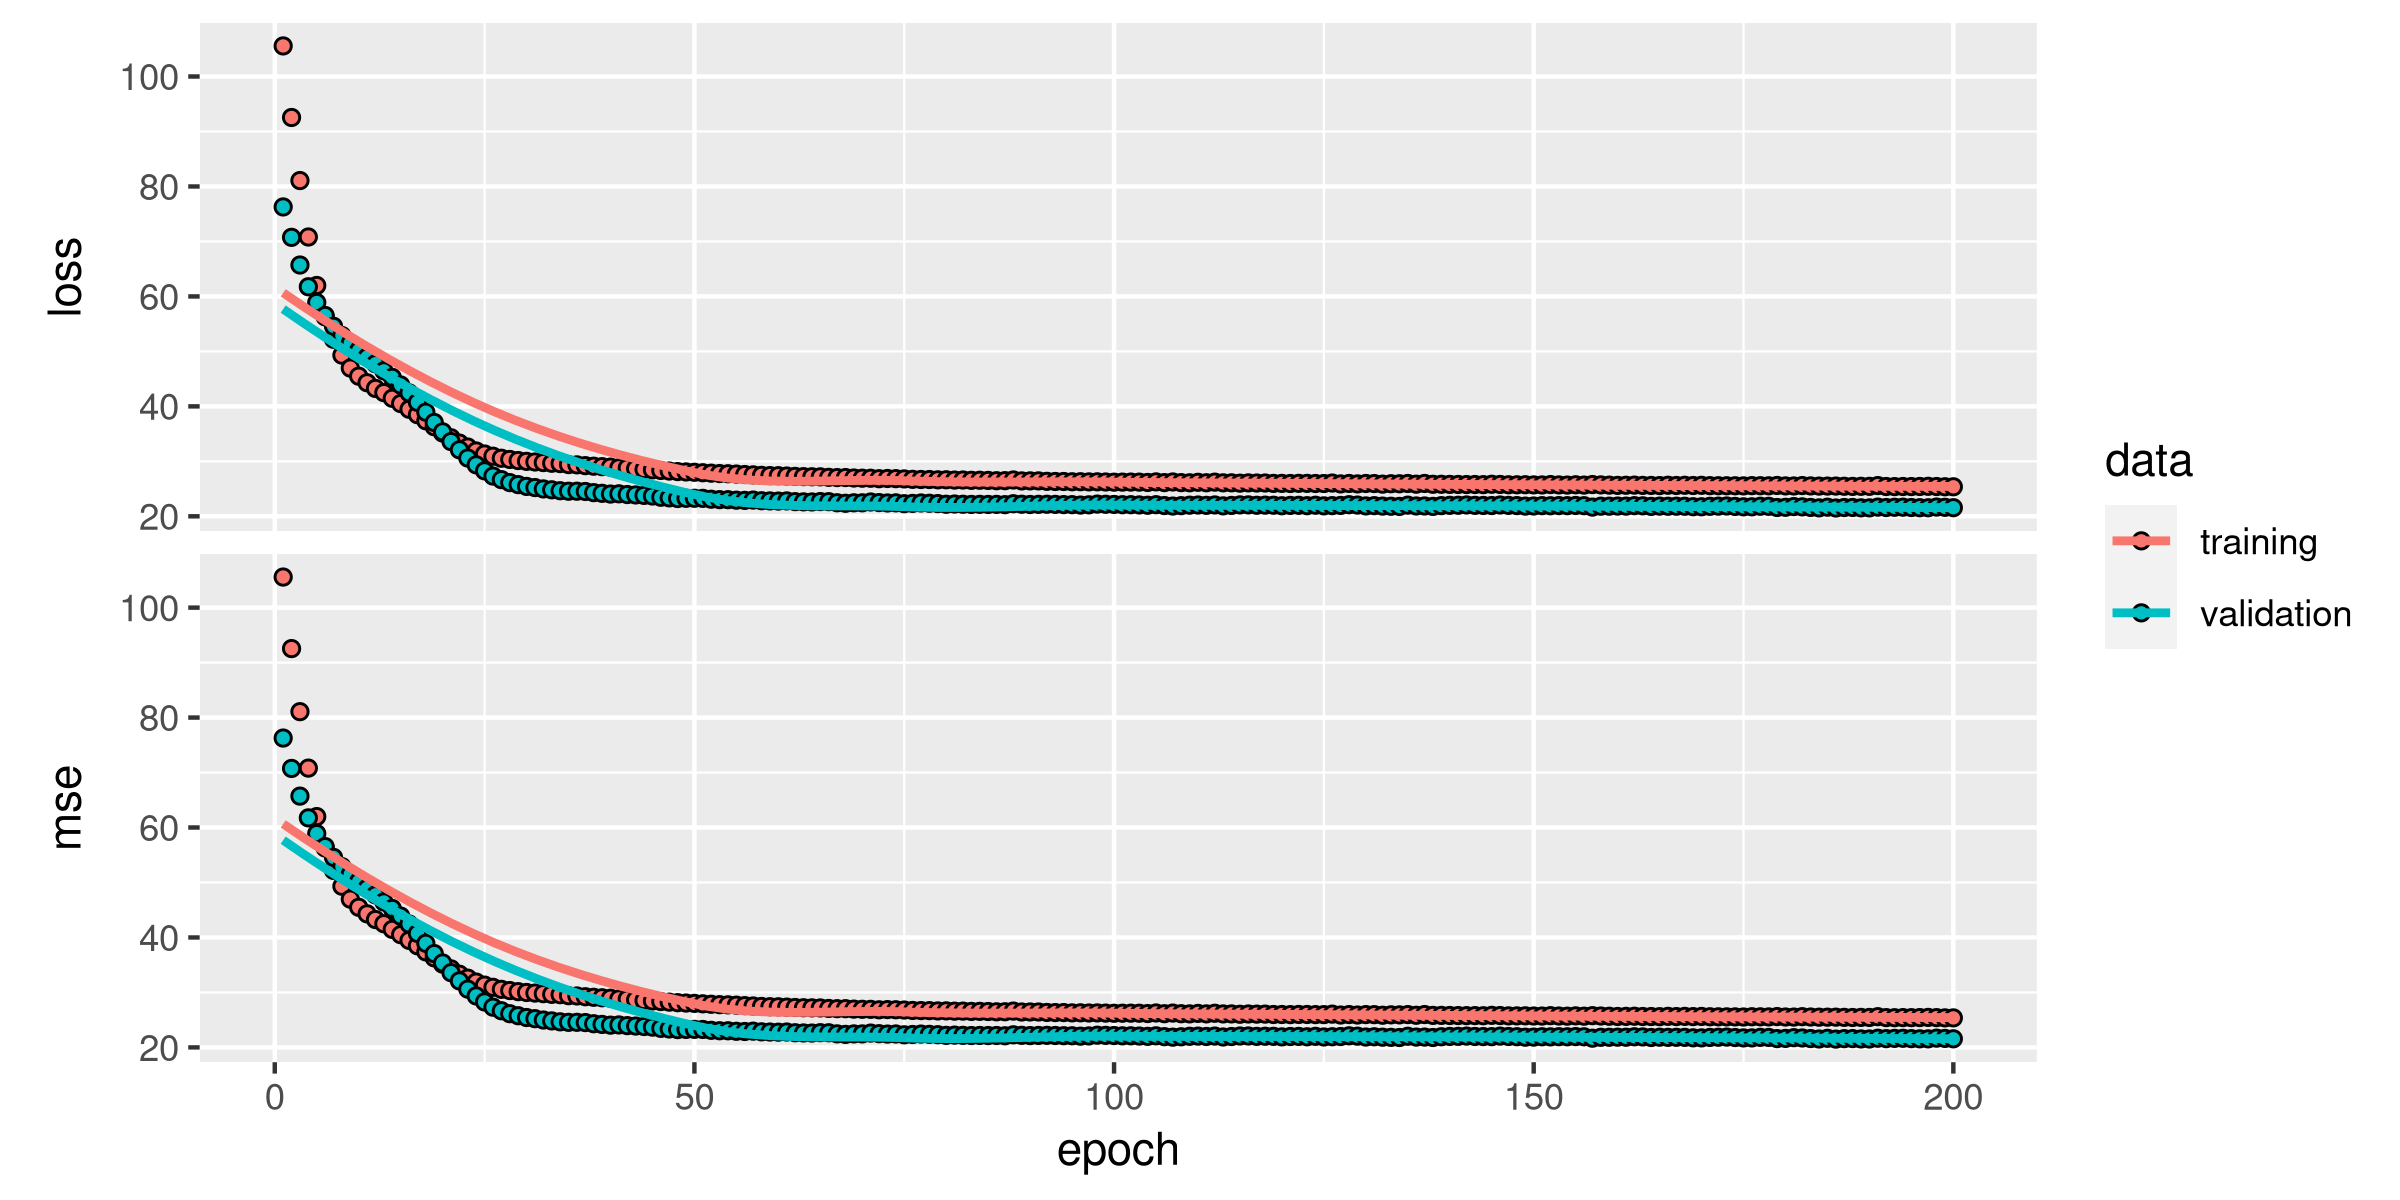

In [51]:
plot(trained_model6)

In [52]:
evaluate(model6, X_train, y_train)

loss     mse 
24.9503 24.9503

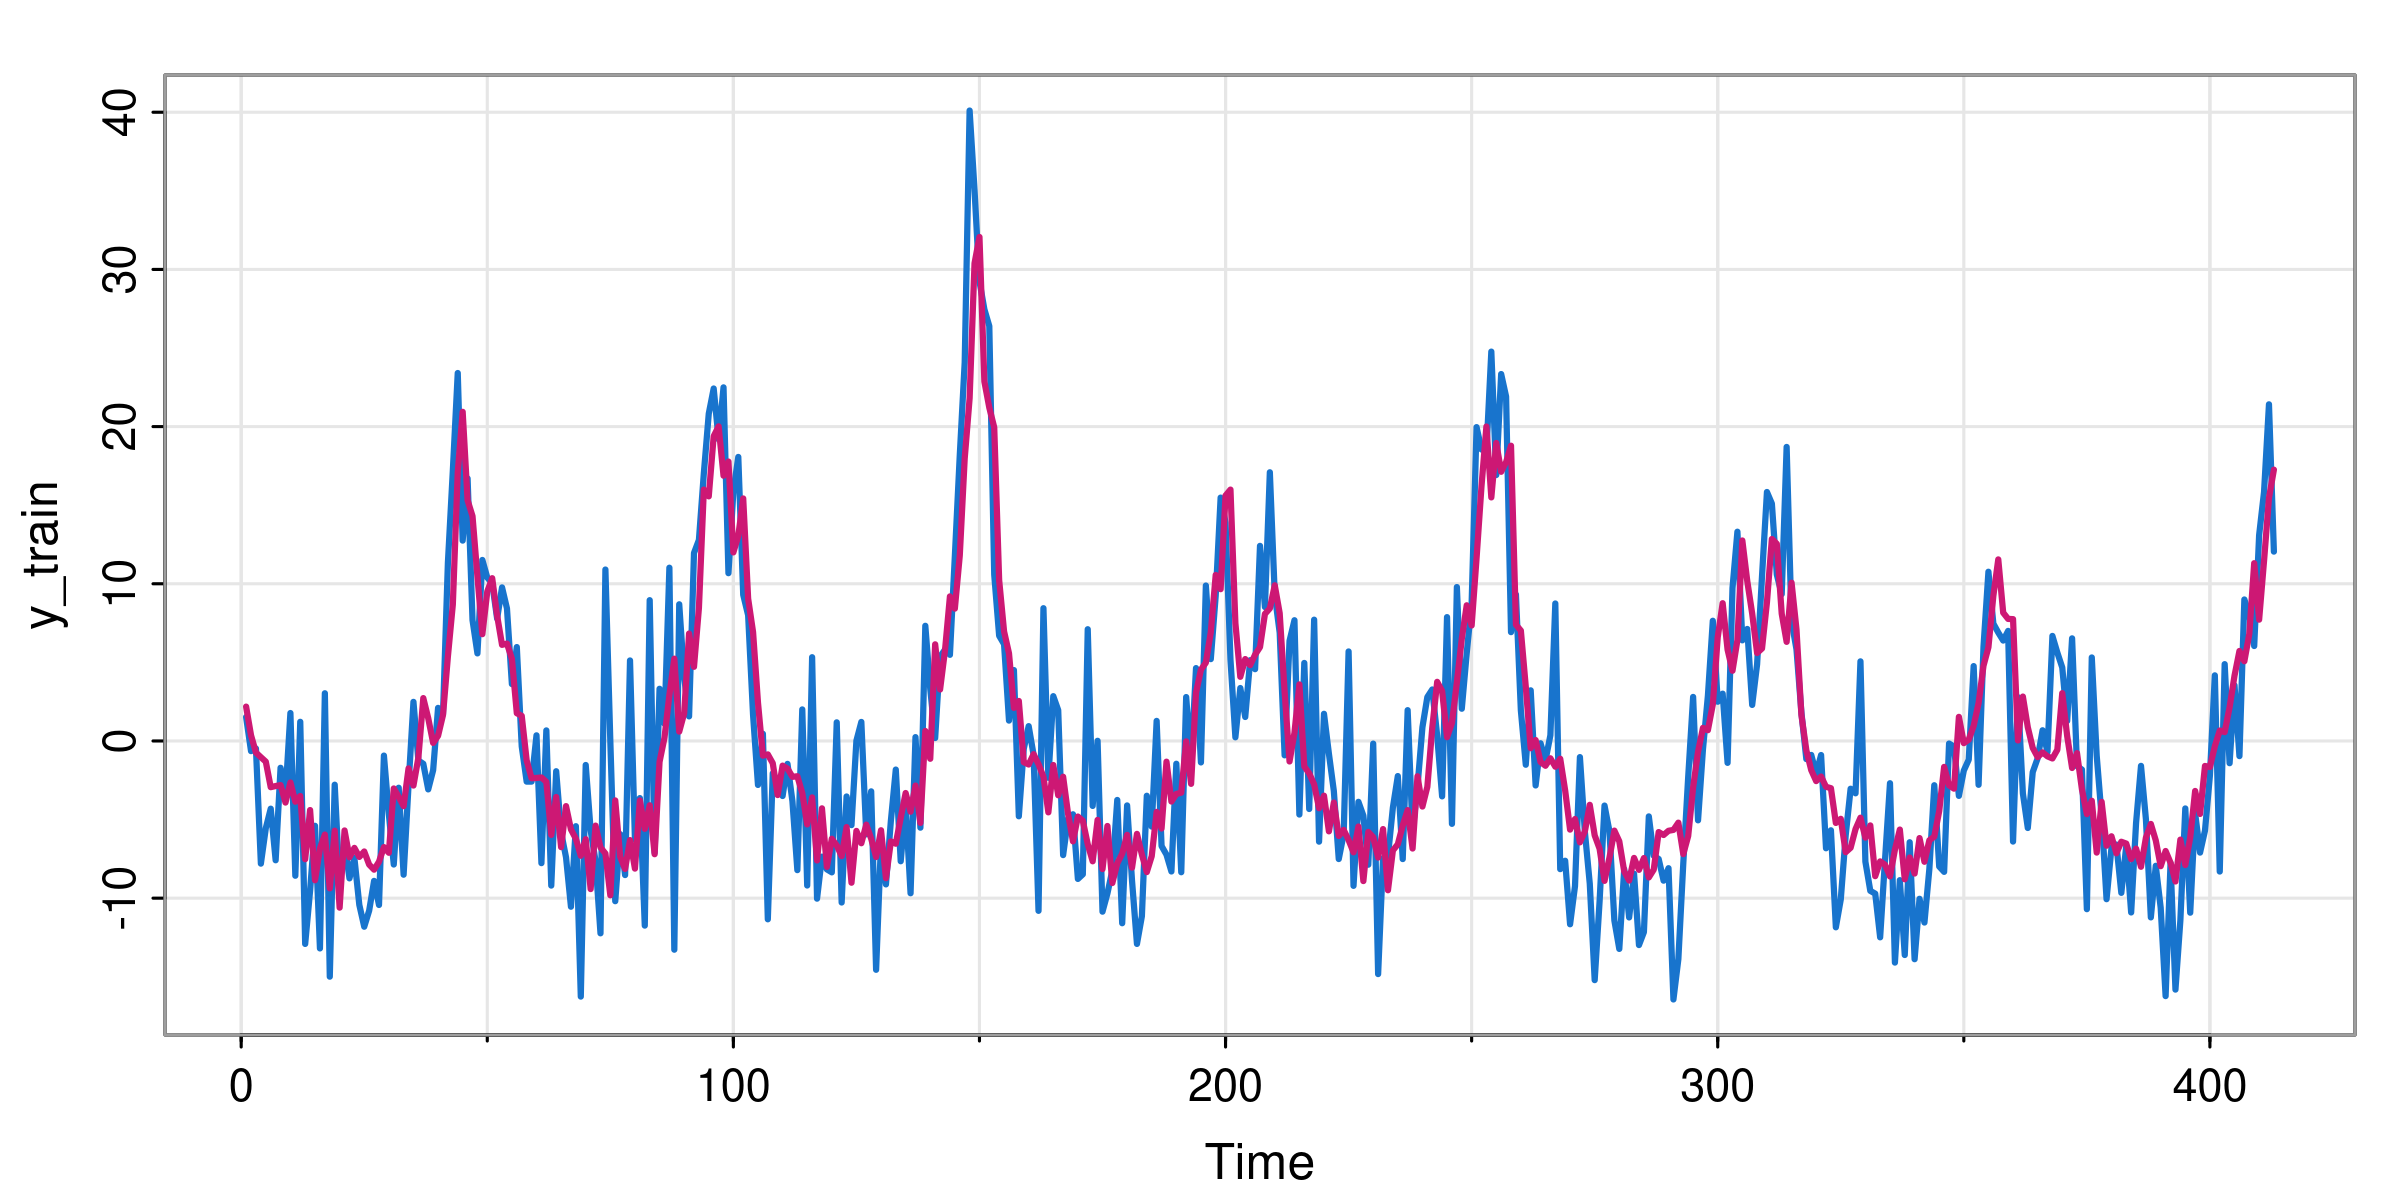

In [53]:
y6 = predict(model6,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y6, col=6, lwd=2)

## Modelo 7: LSTM

La red recurrente LSTM funciona igual que la red RNN en principio, pero tiene más "gates" y parámetros internos para permitir guardar más estado interno. Estas redes son muy usadas para series temporales.

In [54]:
# initialize our model
model7 <- keras_model_sequential()

model7 %>%
    layer_lstm(input_shape = dim(X_train)[2:3], units = 8, activation="relu") %>%
    layer_dense(units = 1)

In [55]:
summary(model7)

Model: "sequential_6"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm (LSTM)                        (None, 8)                       384         
 dense_10 (Dense)                   (None, 1)                       9           
Total params: 393
Trainable params: 393
Non-trainable params: 0
________________________________________________________________________________


In [56]:
model7 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [57]:
trained_model7 <- model7 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


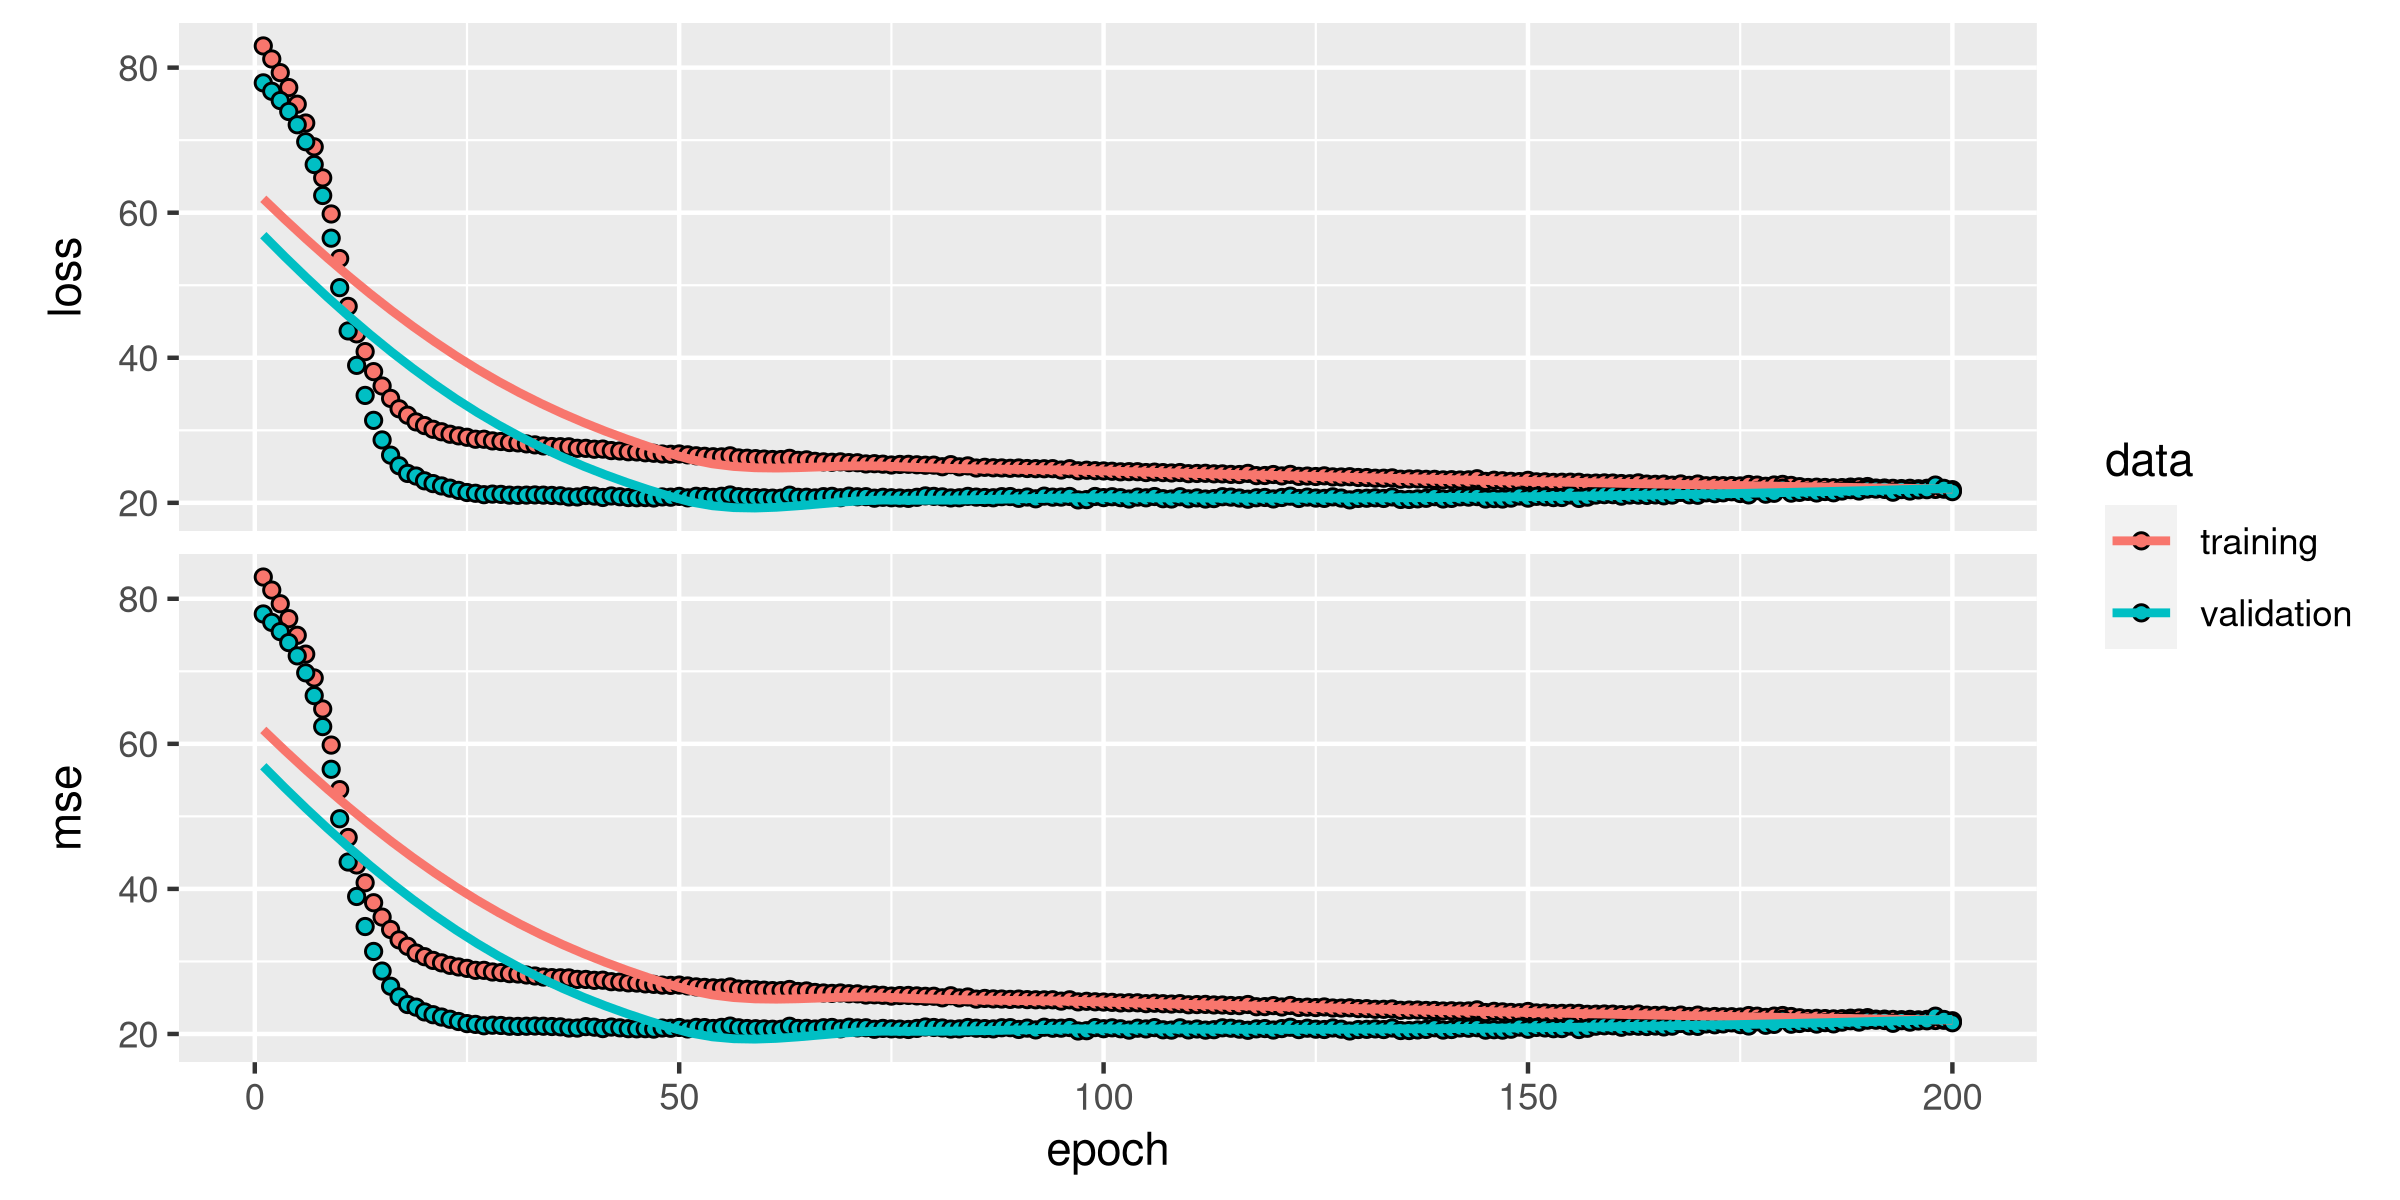

In [58]:
plot(trained_model7)

In [59]:
evaluate(model7, X_train, y_train)

loss      mse 
21.86091 21.86091

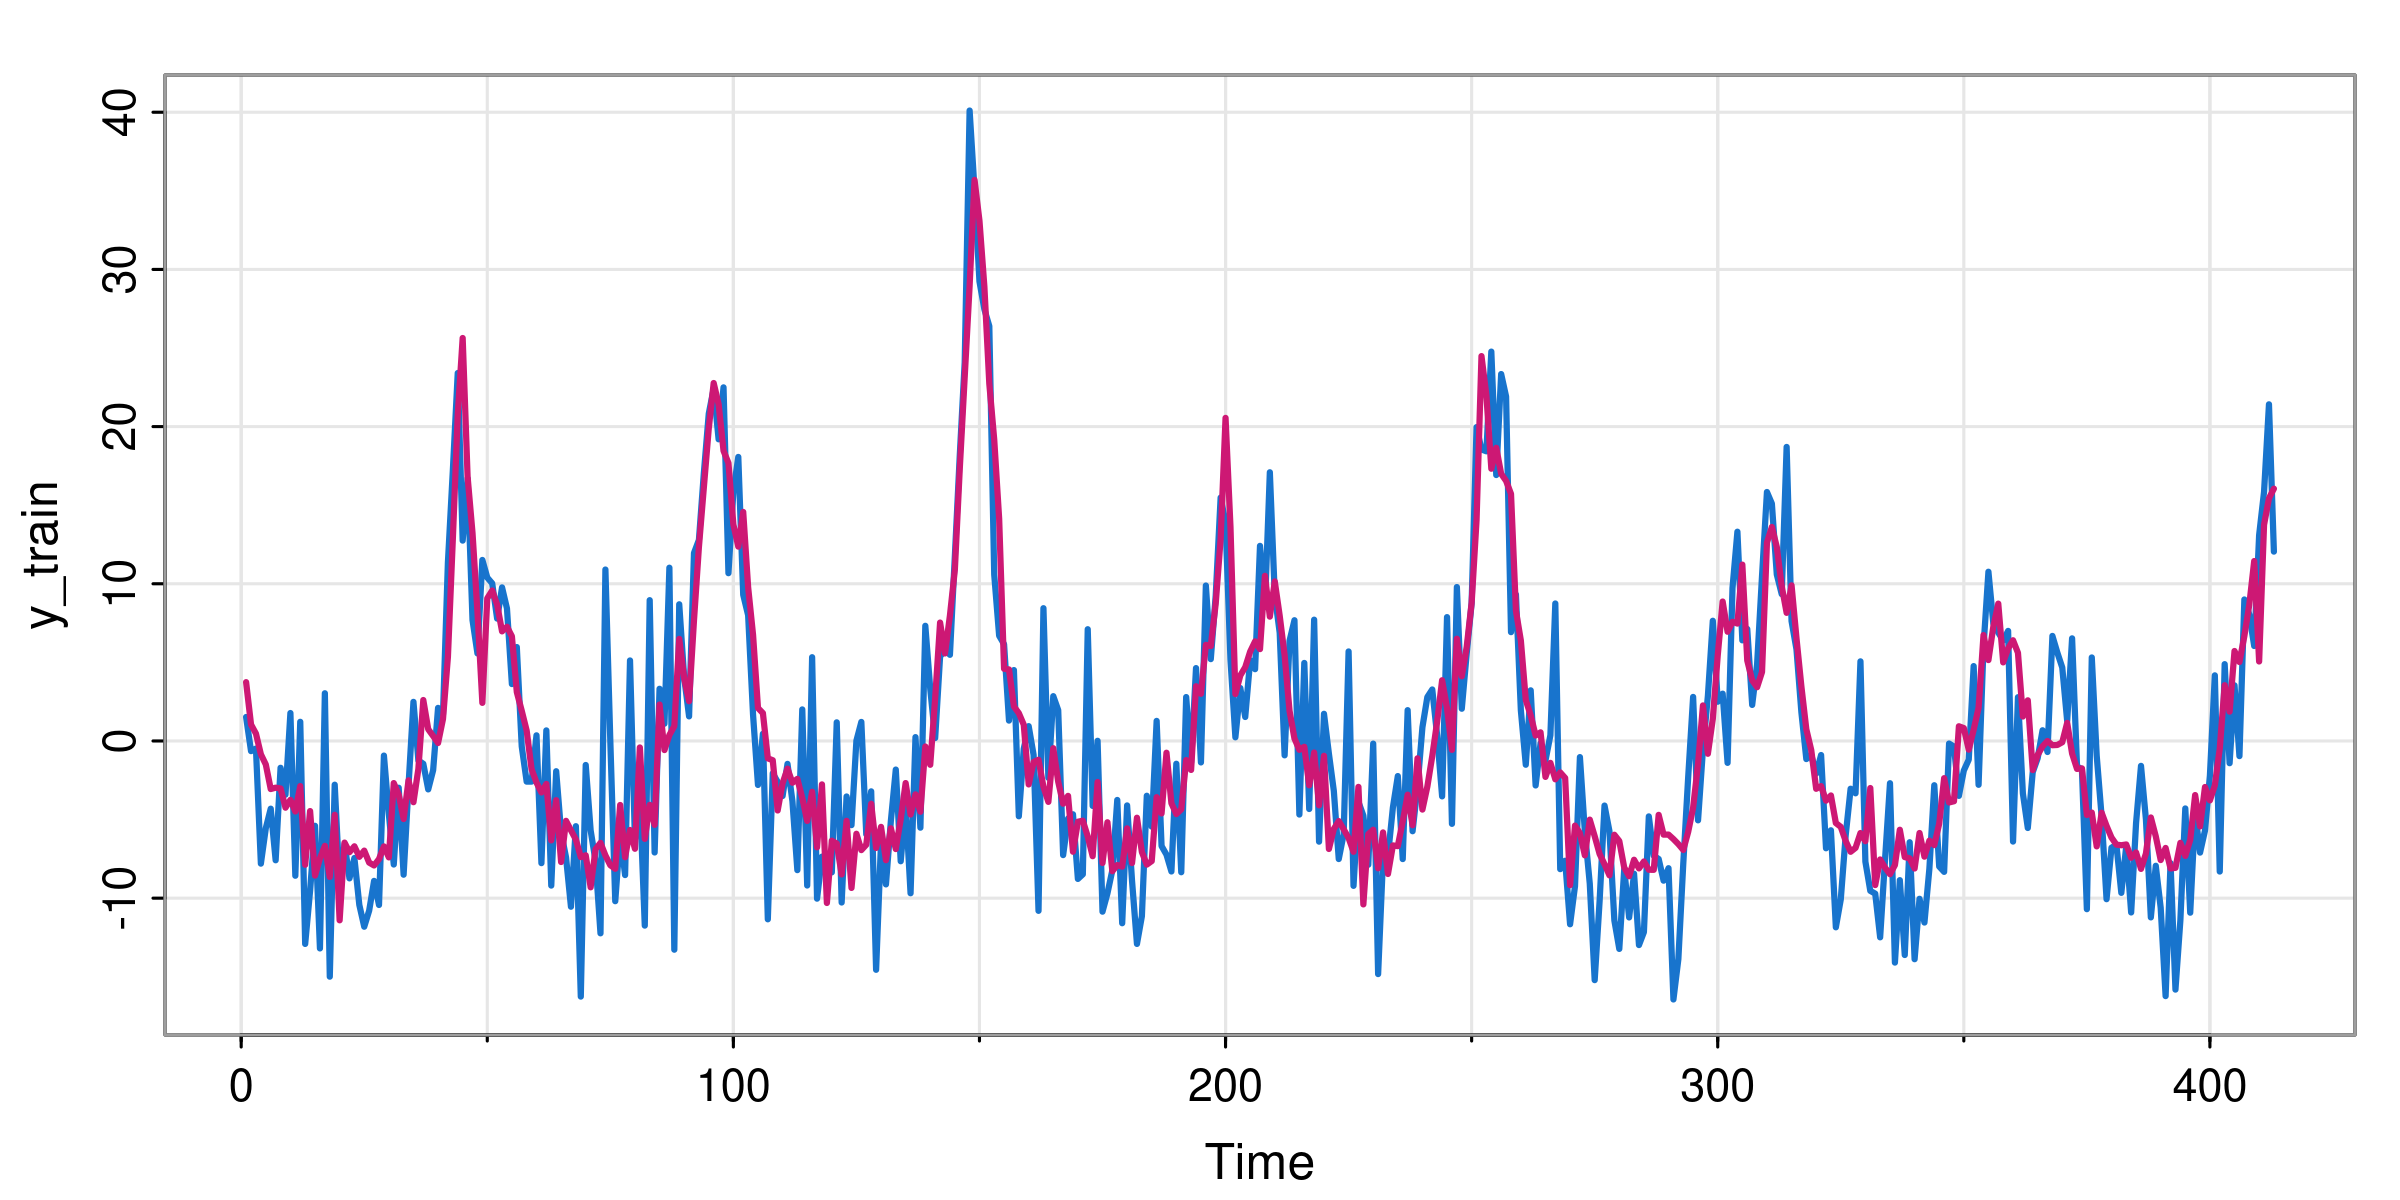

In [60]:
y7 = predict(model7,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y7, col=6, lwd=2)

## Modelo 8: LSTM +  capas

Agreguemos alguna capa densa más.

In [61]:
# initialize our model
model8 <- keras_model_sequential()

model8 %>%
    layer_dense(input_shape = dim(X_train)[2:3], units = 8, activation = "relu") %>%
    layer_lstm(units = 8, activation="relu") %>%
    layer_dense(units = 8, activation="relu") %>%
    layer_dense(units = 1)

In [62]:
summary(model8)

Model: "sequential_7"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_13 (Dense)                   (None, 3, 8)                    32          
 lstm_1 (LSTM)                      (None, 8)                       544         
 dense_12 (Dense)                   (None, 8)                       72          
 dense_11 (Dense)                   (None, 1)                       9           
Total params: 657
Trainable params: 657
Non-trainable params: 0
________________________________________________________________________________


In [63]:
model8 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [64]:
trained_model8 <- model8 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


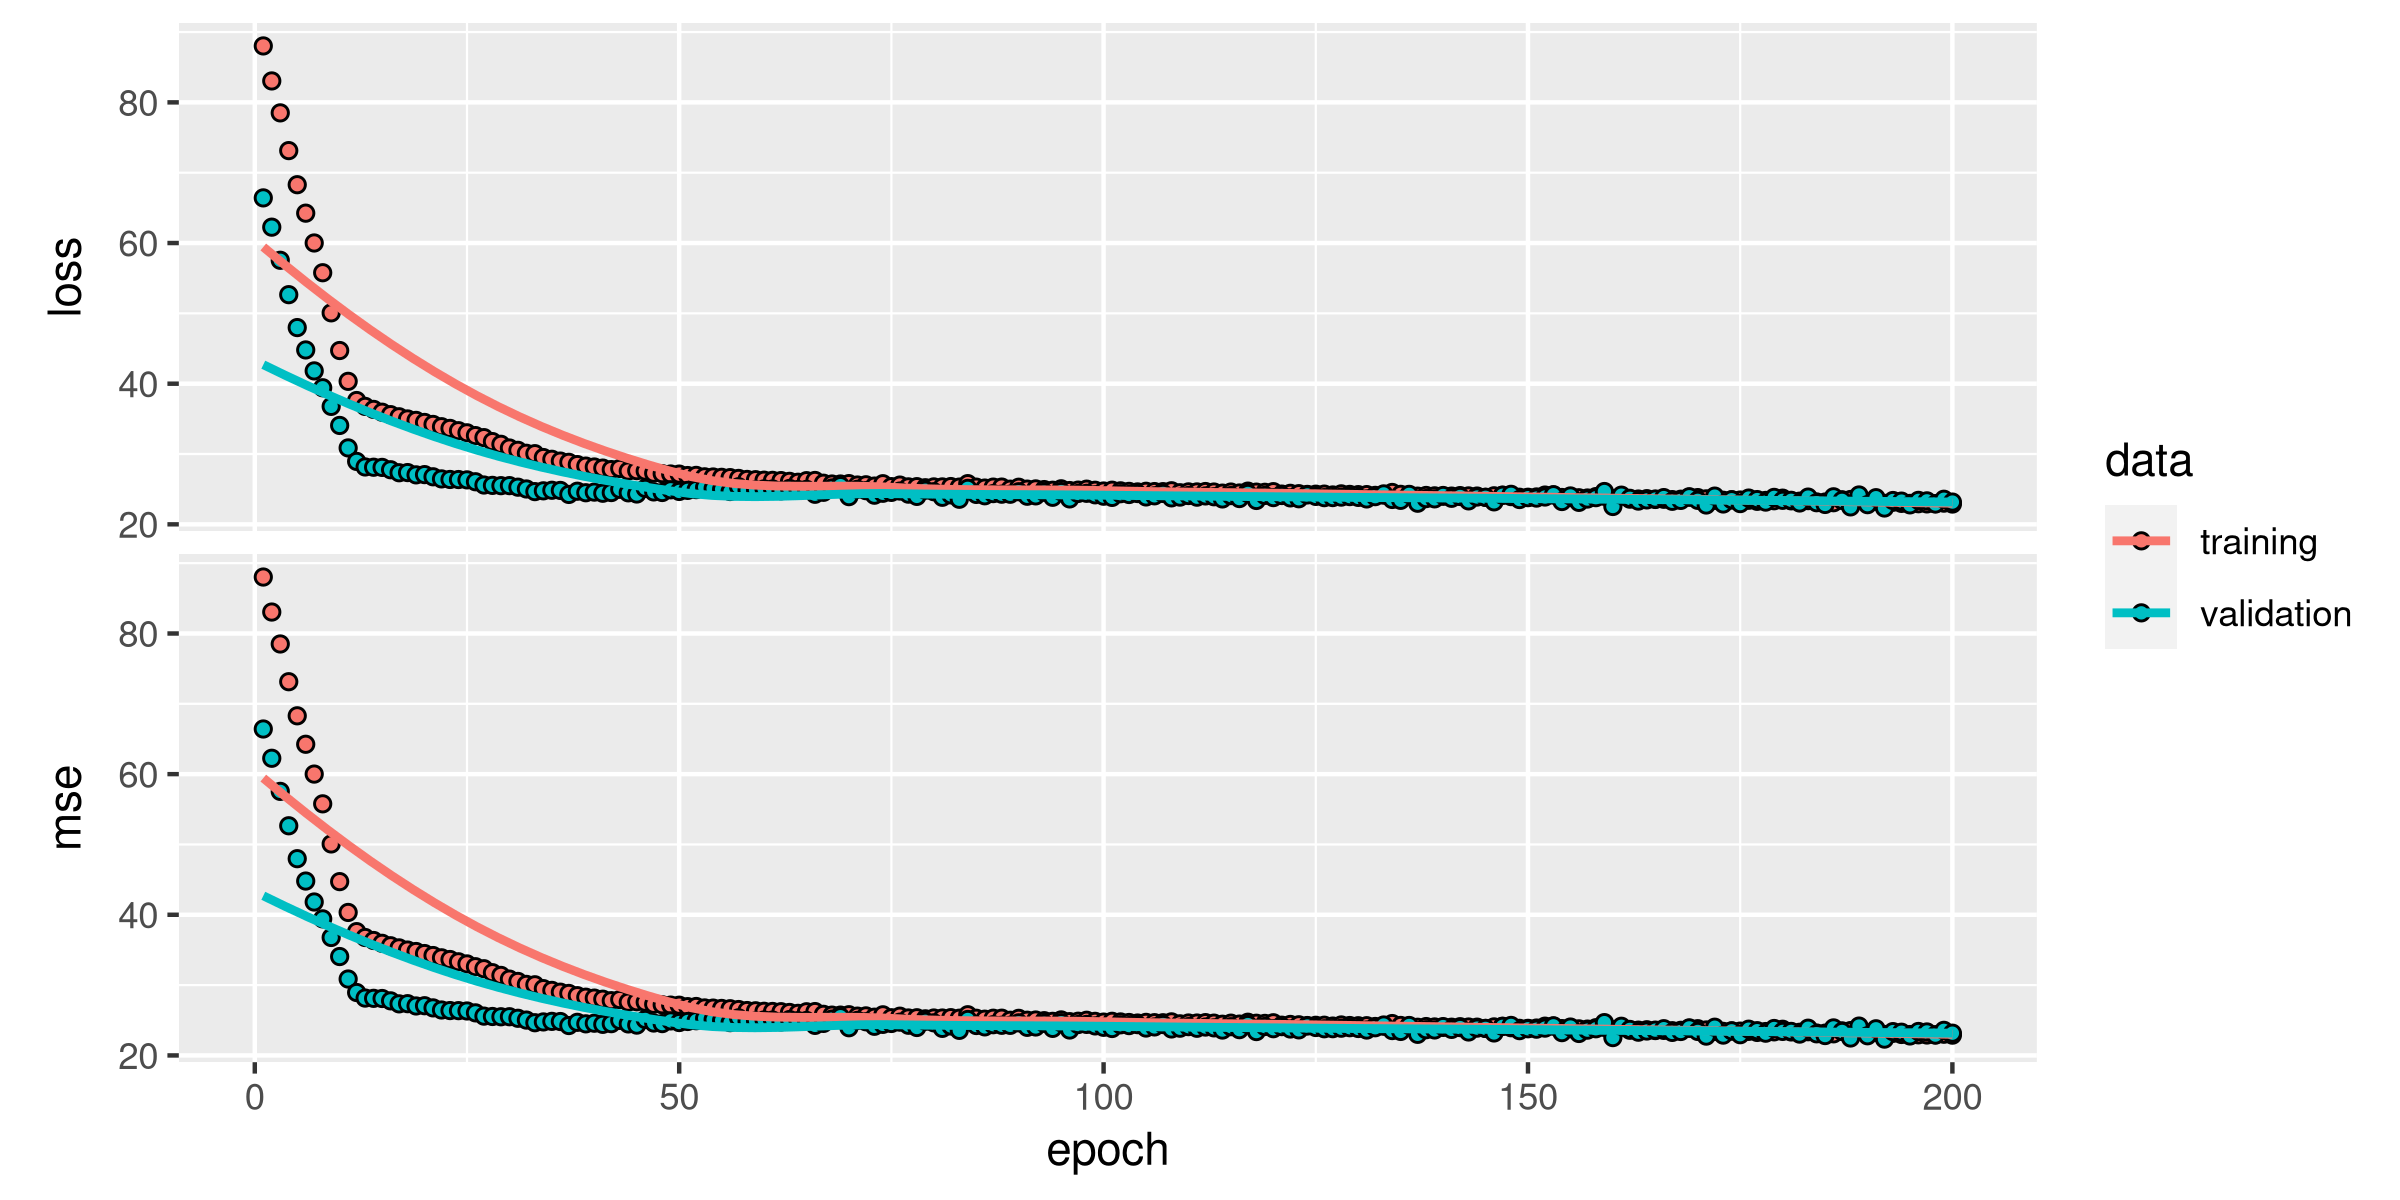

In [65]:
plot(trained_model8)

In [66]:
evaluate(model8, X_train, y_train)

loss      mse 
22.70648 22.70648

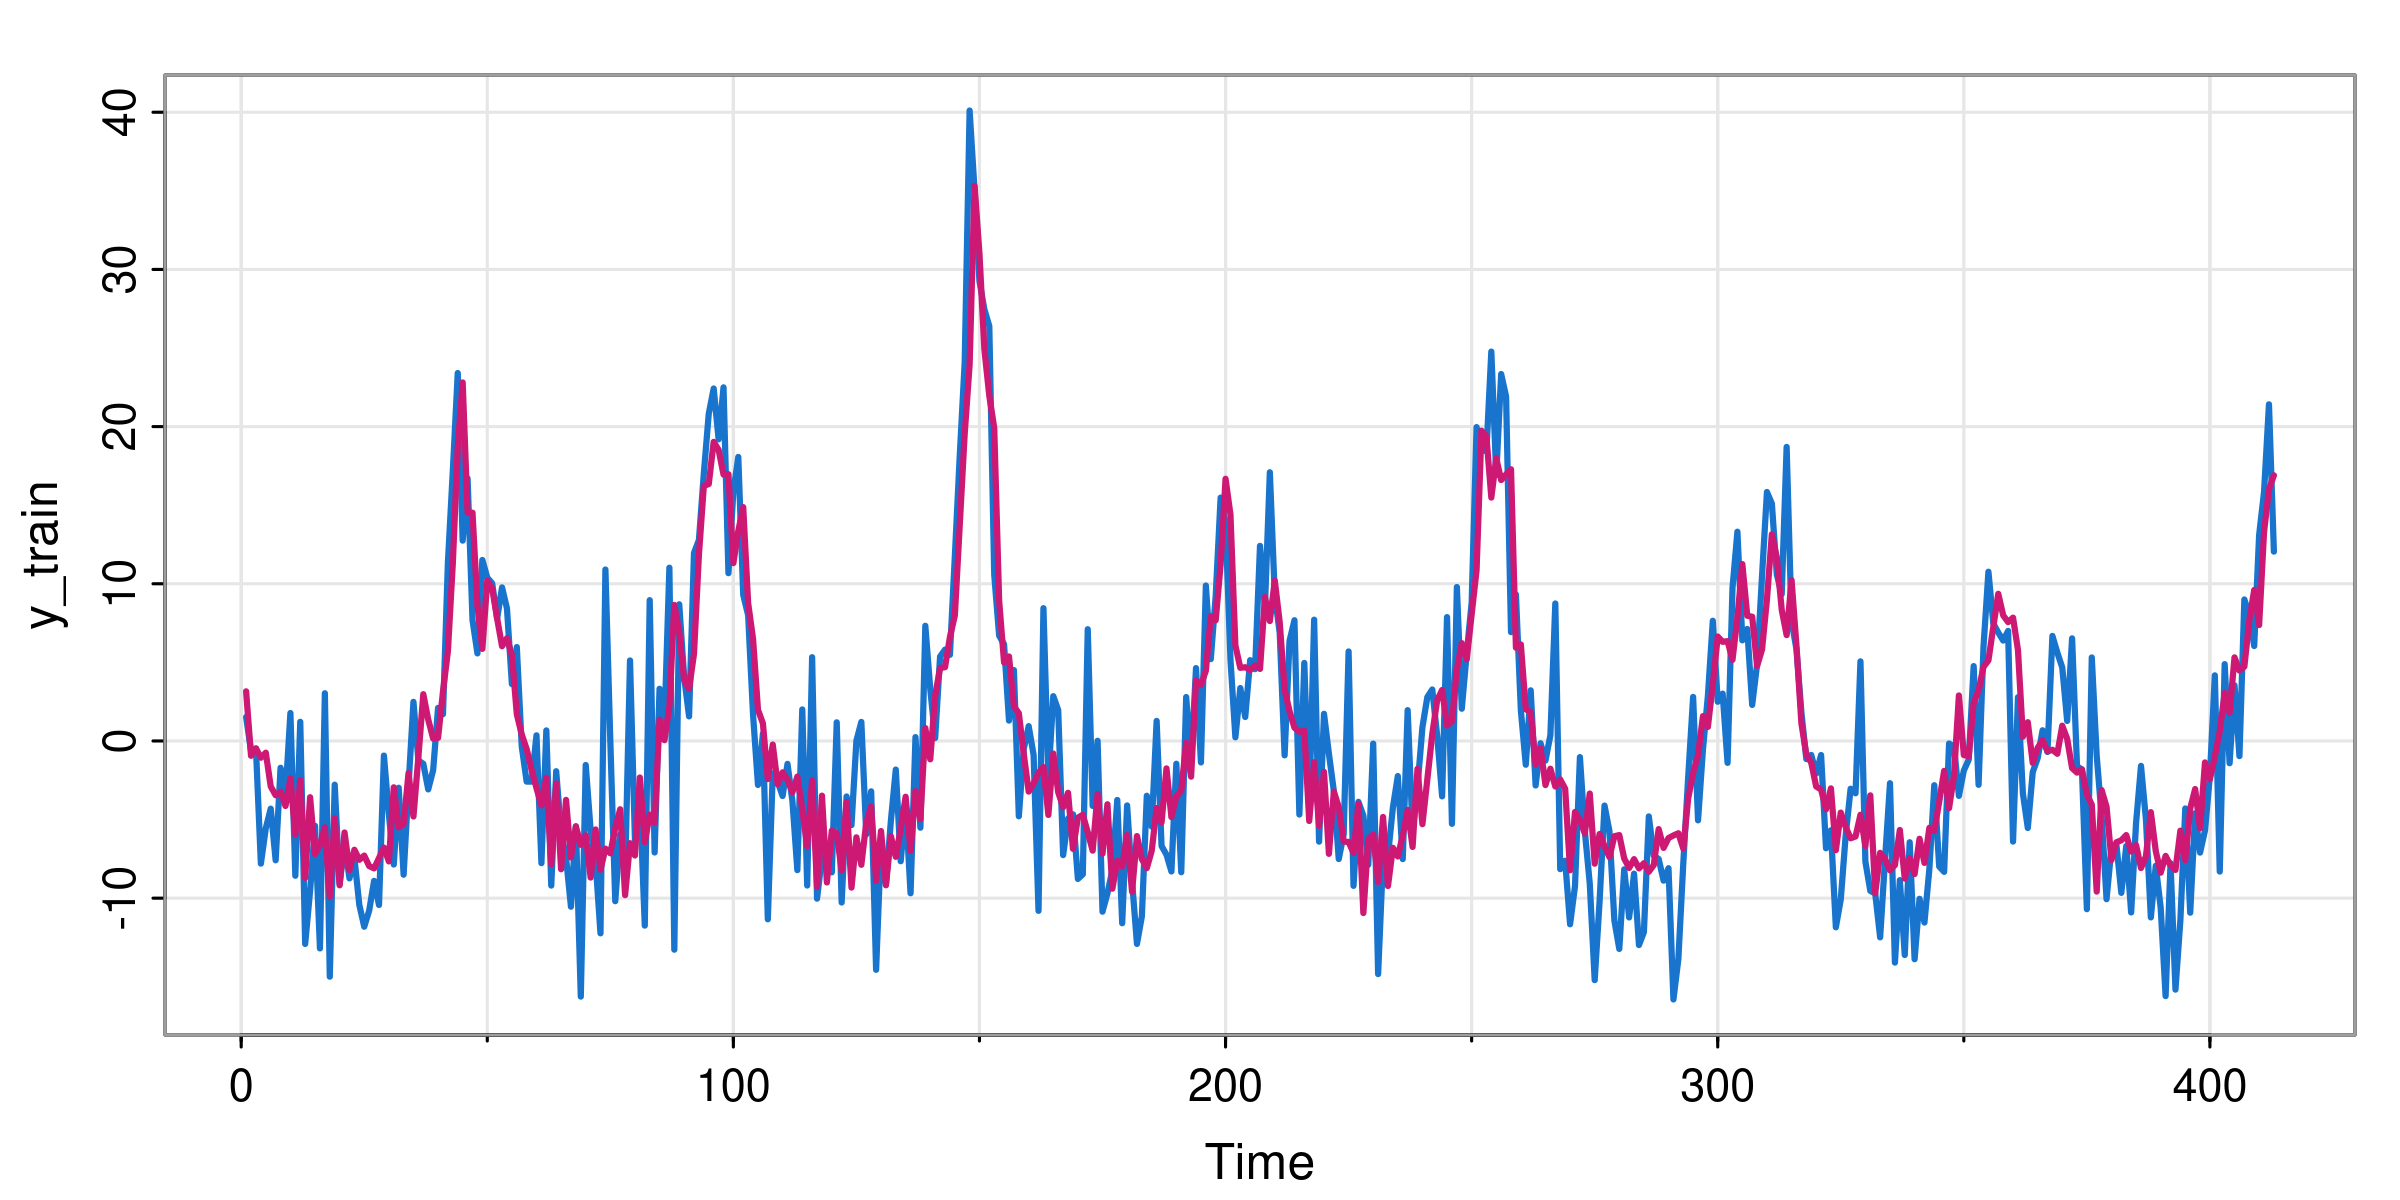

In [67]:
y8 = predict(model8,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y8, col=6, lwd=2)

## Evaluación.

Evaluemos algunos de estos modelos haciendo la predicción sobre los años que faltan.

In [68]:
x_test = x[time(x)>=1978]
x_test = ts(x_test, start=1978, freq=52)

sint = sin(2*pi*time(x_test))
cost = cos(2*pi*time(x_test))

In [69]:
n=length(x_test)

X_test = array(,dim=c(n-window-pred+1,window,3)) #el ultimo son los features
y_test = matrix(,n-window-pred+1,pred)

for (i in 1:(n-window-pred+1)) {
    X_test[i,,1] = x[i:(i+window-1)]
    X_test[i,,2] = sint[i:(i+window-1)]
    X_test[i,,3] = cost[i:(i+window-1)]
    y_test[i,] = x[(i+window):(i+window+pred-1)]
}
dim(X_test)
dim(y_test)

[1] 89  3  3

[1] 89  1

In [70]:
evaluate(model8,X_test,y_test)

loss      mse 
27.15063 27.15063

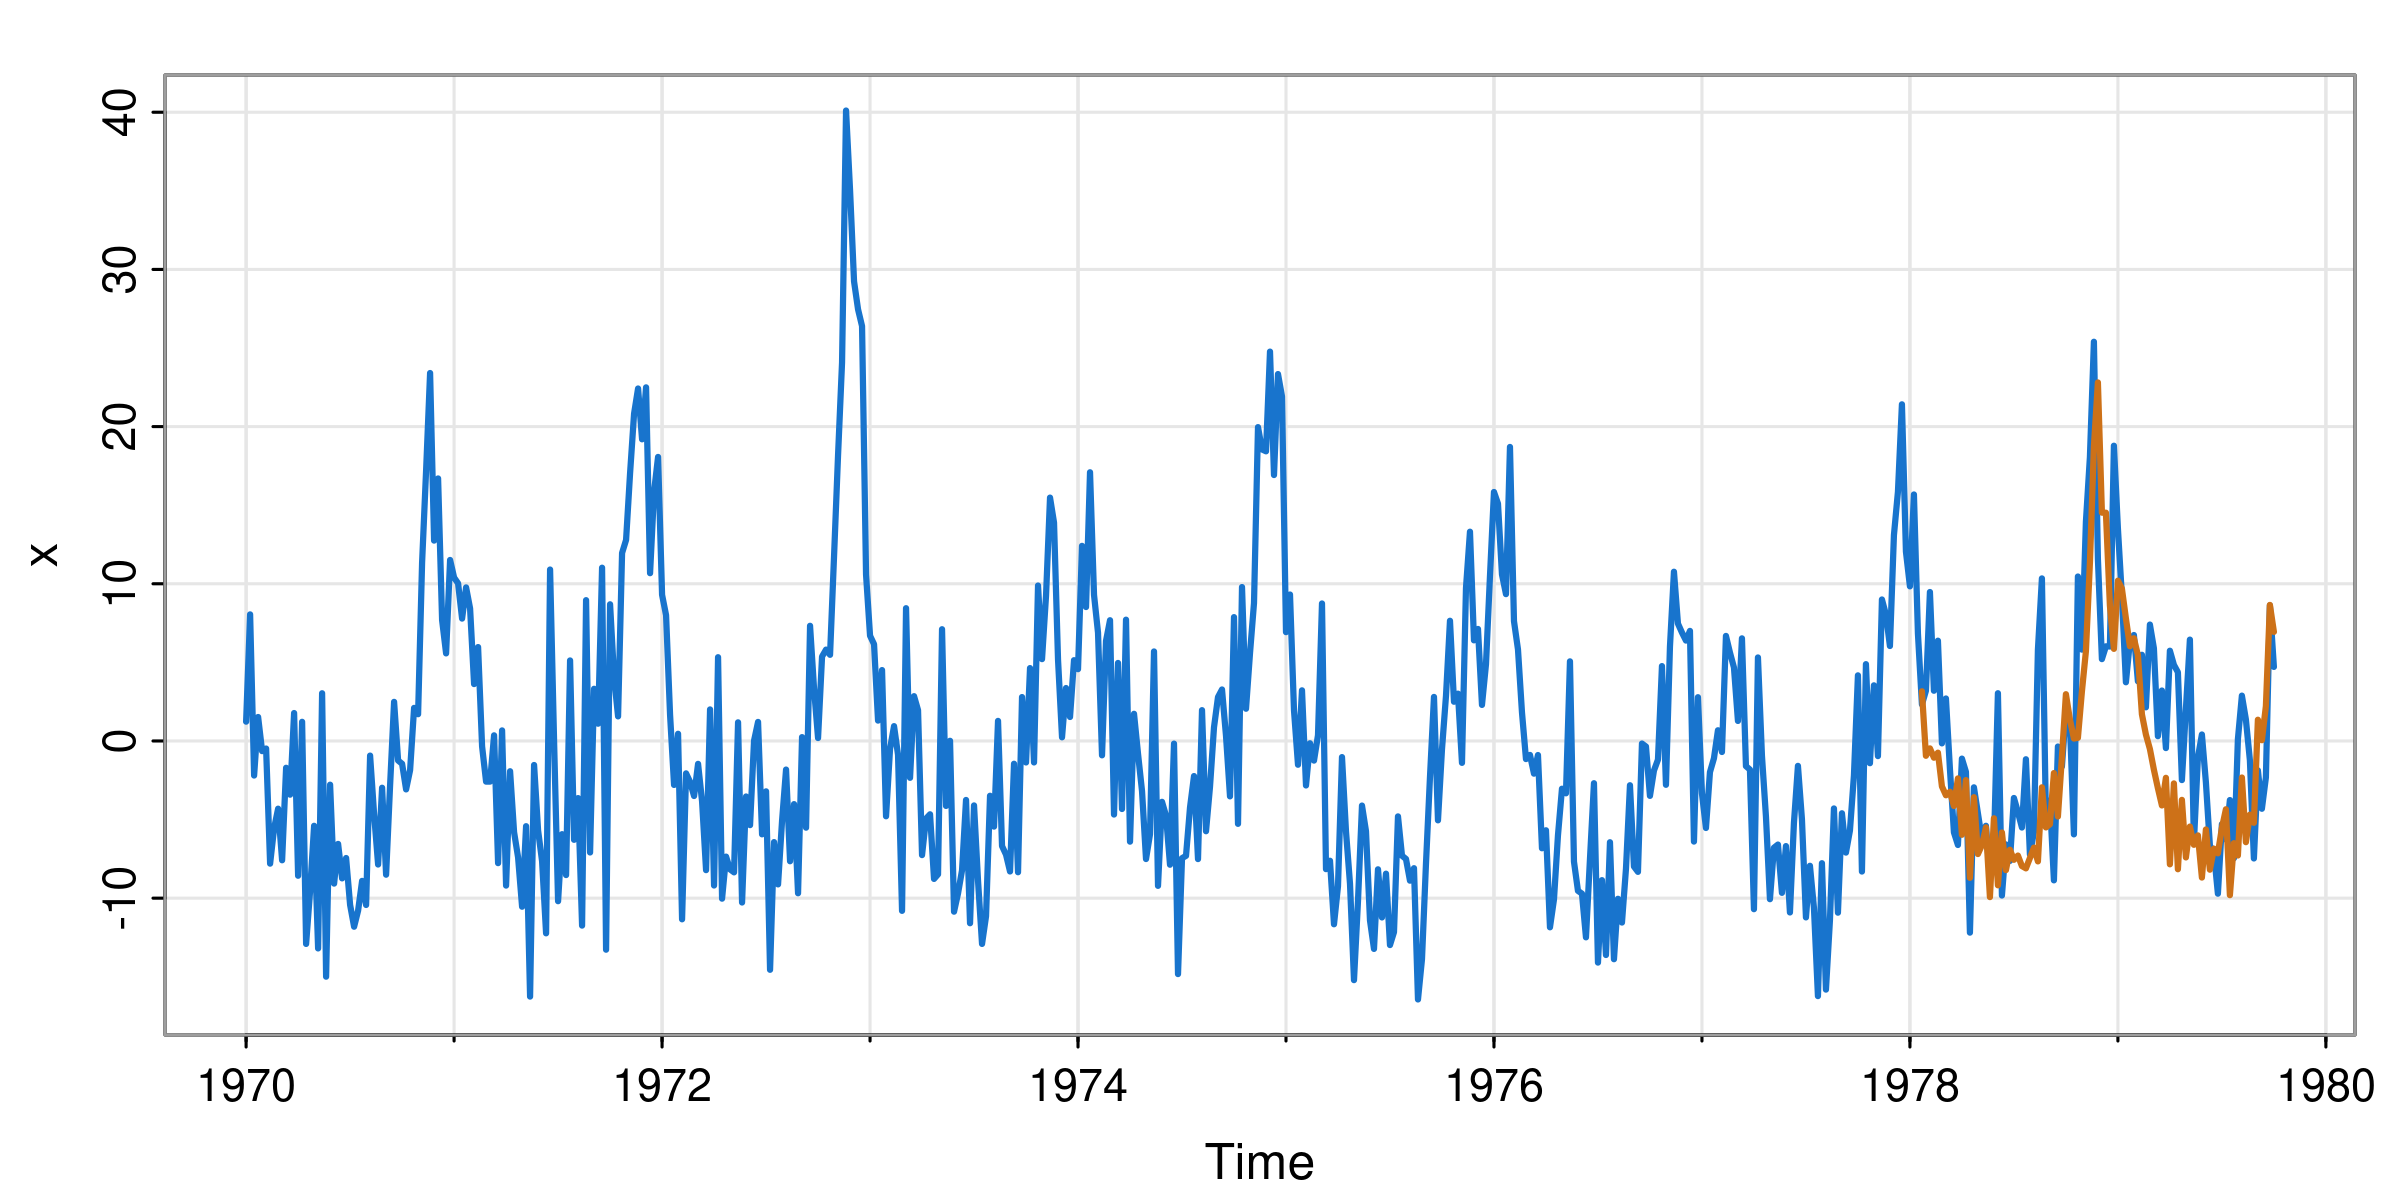

In [71]:
y8_test = predict(model8,X_test)
y8_test = ts(y8_test, start=1978+3/52, freq=52)
#y8 = ts(y8, start=1970, freq=52)

tsplot(x, col=4, lwd=2)
lines(y8, col=6, lwd=2)
lines(y8_test, col=7, lwd=2)